<a href="https://colab.research.google.com/github/tjtmddnjswkd/capstone/blob/master/KB%20crawling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 종찬 승원 보시오!

부터,내지,에,에도,및,을,를,또는,규정은,규정에,죄에,의,은,는,나

In [ ]:
from  google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 크롤링(Selenium, BeautifulSoup)
- Selenium으로 webdriver를 생성해 동적 크롤링 수행 후,
- 가져온 html 데이터를 BeatifulSoup으로 파싱

In [ ]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [833 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [977 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,231 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,099 kB]
Get:13 http://archive.ubuntu.co

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from bs4 import BeautifulSoup
import pandas as pd
import random

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

# driver=webdriver.Chrome()

In [ ]:
from selenium.webdriver.common.by import By
import re


# 페이지 접근
url = f"https://elaw.klri.re.kr/kor_service/lawAllSearch.do?pCode=01"
driver.get(url)
driver.implicitly_wait(random.randint(3,7))

# 카테고리 정보 가져오기
# (이후에 카테고리별 법령 개수랑 크롤링된 개수랑 비교하면서 반복문 탈출필요)
# for i in range(2,47): #시작이 2부터임
for i in range(42,47):
  cat_button = driver.find_element(By.XPATH, f'//*[@id="tree_{i}_a"]')
  cat_name = cat_button.text.split()[1]
  cat_cnt = int(cat_button.text.split('(')[-1].replace(')',''))
  print(f'\n>>> {cat_name} 카테고리 크롤링 시작...')

  # 카테고리 클릭
  driver.execute_script("arguments[0].click();", cat_button)
  driver.implicitly_wait(random.randint(3,7))

  # 페이지 클릭
  final_df = pd.DataFrame()
  tot_cnt = 0
  for p in range(2,10):
    # 페이지 내 특정 html 요소로 접근
    driver.switch_to.frame('indexFrame')
    if p > 2:
      page_button = driver.find_element(By.XPATH, f'//*[@id="container"]/div/div[3]/a[{p}]')
      page_button.click()
      driver.implicitly_wait(random.randint(3,7))

    # 페이지 내 각 법령마다 처리해주기: 20개씩 나와있음
    for i in range(1, 21):
      tot_cnt += 1

      # 해당 카테고리의 법령 개수보다 크롤링된 법령 개수가 많아지면 반복문 탈출
      if tot_cnt > cat_cnt:
        break

      # 세부 페이지로 접근
      try:
        driver.switch_to.frame('indexFrame')
      except:
        pass
      subpage_button = driver.find_element(By.XPATH, f'//*[@id="{str(i)}"]/td[2]/p/a')
      subpage_name = subpage_button.text.split('\n')[0]

      driver.execute_script("arguments[0].click();", subpage_button)
      driver.implicitly_wait(random.randint(3,7))

      # 영문/한글 체크 선택
      driver.switch_to.window(driver.window_handles[-1])
      driver.get(driver.current_url.replace("ENG","KOR"))
      driver.implicitly_wait(random.randint(3,7))

      # 페이지 내 특정 html 요소로 접근
      driver.switch_to.frame('lawViewContent')
      driver.implicitly_wait(random.randint(3,7))

      # 행, 호, 글 부분만 선택해주기
      r = driver.page_source
      soup = BeautifulSoup(r, "html.parser")

      # 한글, 영어 매칭해서 df로 저장
      df = pd.DataFrame()
      for c in ['none', 'hang']:
        document = soup.find_all('div', class_=c)
        kor, eng = [], []
        kor_cnt, eng_cnt = 0, 0
        for d in document:
          d_text = d.get_text()
          if not d_text or (d_text[0] == '[' and d_text[-1] == ']'):
            continue
          else:
            pattern = re.compile('[가-힣]+')
            if len(pattern.findall(d_text)) >= 1:   # 한글 부분
              # if eng_cnt == 1:
                kor.append(d_text)
                kor_cnt += 1
            else:              # 영어 부분
              if kor_cnt != 0 and eng_cnt != 0:
                if kor_cnt == eng_cnt:
                  df = pd.concat([df, pd.DataFrame({'category':cat_name, 'law_name':subpage_name, 'en':eng, 'ko':kor})],
                                 ignore_index=True)
                kor, eng = [], []
                kor_cnt, eng_cnt = 0, 0
              eng.append(d_text)
              eng_cnt += 1

      # 각 법령 문서 취합
      print(f'{tot_cnt}번째 법령 취합 완료: row 총 {len(df)}개')
      final_df = pd.concat([final_df, df], ignore_index=True)

      # 다시 원래 위치로 되돌아가기
      driver.close()
      driver.switch_to.window(driver.window_handles[0])
      driver.implicitly_wait(random.randint(3,7))

    # 페이지 수준 반복문 탈출(해당 카테고리 법령 수집 완료)
    if tot_cnt > cat_cnt:
        break

  # 해당 카테고리 데이터 저장
  print(f'>>> {cat_name} 카테고리 크롤링 완료...(row 총 {len(final_df)}개)\n')
  final_df.to_csv(f'/content/drive/MyDrive/KBdata/{cat_name}_df.csv')


>>> 육운·항공·관광 카테고리 크롤링 시작...
1번째 법령 취합 완료: row 총 122개
2번째 법령 취합 완료: row 총 85개
3번째 법령 취합 완료: row 총 57개
4번째 법령 취합 완료: row 총 260개
5번째 법령 취합 완료: row 총 16개
6번째 법령 취합 완료: row 총 33개
7번째 법령 취합 완료: row 총 357개
8번째 법령 취합 완료: row 총 217개
9번째 법령 취합 완료: row 총 196개
10번째 법령 취합 완료: row 총 146개
11번째 법령 취합 완료: row 총 378개
12번째 법령 취합 완료: row 총 50개
13번째 법령 취합 완료: row 총 86개
14번째 법령 취합 완료: row 총 107개
15번째 법령 취합 완료: row 총 216개
16번째 법령 취합 완료: row 총 134개
17번째 법령 취합 완료: row 총 66개
18번째 법령 취합 완료: row 총 265개
19번째 법령 취합 완료: row 총 265개
20번째 법령 취합 완료: row 총 158개
21번째 법령 취합 완료: row 총 424개
22번째 법령 취합 완료: row 총 108개
23번째 법령 취합 완료: row 총 542개
24번째 법령 취합 완료: row 총 176개
25번째 법령 취합 완료: row 총 229개
26번째 법령 취합 완료: row 총 101개
27번째 법령 취합 완료: row 총 145개
28번째 법령 취합 완료: row 총 37개
29번째 법령 취합 완료: row 총 139개
30번째 법령 취합 완료: row 총 127개
31번째 법령 취합 완료: row 총 373개
32번째 법령 취합 완료: row 총 191개
33번째 법령 취합 완료: row 총 73개
34번째 법령 취합 완료: row 총 65개
35번째 법령 취합 완료: row 총 49개
36번째 법령 취합 완료: row 총 77개
37번째 법령 취합 완료: row 총 24개
38번째 법령 취합 완료: row 총 195개
39번째 

In [ ]:
final_df

,category,law_name,en,ko
0,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The purpose of this Act is to provide for matt...,이 법은 「대한민국과 아메리카합중국 간의 상호방위조약 제4조에 의한 시설과 구역 및...
1,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The term “Korean national worker(s) for the Un...,"이 법에서 ""주한미군 소속 한국인 근로자""란 다음 각 호의 어느 하나에 해당하는 사..."
2,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A Korean national worker for the United States...,주한미군 소속 한국인 근로자는 이 법에 따른 지원금을 지급받으려는 때에는 대통령령으...
3,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) Where Korean national workers for the Unit...,① 국가는 기존 방위비분담특별협정이 종료되고 다음 방위비분담특별협정이 발효되지 아니...
4,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(2) A subsidy paid under paragraph (1) shall b...,② 제1항에 따라 지급되는 지원금은 「고용보험법」 제46조제1항제1호에 따른 금액으...
5,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) The detailed method for calculation and pa...,"③ 제1항 및 제2항에 따른 지원금의 구체적인 산정, 지급 방법 및 지급 기간 등에..."
6,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) Upon the making of a decision to or not to...,① 국방부장관이 지원금을 지급하거나 지급하지 아니하기로 결정한 때에는 7일 이내에 ...
7,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(2) The provisions of the Civil Procedure Act ...,② 제1항의 송달에 관하여는 「민사소송법」의 송달에 관한 규정을 준용한다.
8,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
9,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...


# 2. 데이터 결합
- 크롤링 과정에서 분리저장된 조각파일들을 결합

In [ ]:
# 크롤링 파일조각들 df형태로 리스트화

import pandas as pd
import glob


allFile_list = glob.glob('/content/drive/MyDrive/KBdata/*_df.csv')

allData = []
for file in allFile_list:
    df = pd.read_csv(file)
    allData.append(df.iloc[:,1:])
len(allData)

45


In [ ]:
# 각 df들 전부 결합(merge)

dataMerge = pd.concat(allData, axis=0, ignore_index=True)
dataMerge

,category,law_name,en,ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,"이 법에서 사용하는 용어의 정의는 다음과 같다. <개정 2009. 1. 30., 2..."
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적..."
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 「남북협력기금법」 에 따른 남북협력기금을 지원 또는 ...
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력ㆍ기술개발...
...,...,...,...,...
279015,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
279016,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
279017,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) Procedures for appeal and giving notice of...,③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
279018,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(1) Costs necessary to pay subsidies, etc. und...",① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


In [ ]:
dataMerge.duplicated().sum()

2662

In [ ]:
# 중복행 제거

dataMerge = dataMerge.drop_duplicates()
print(len(dataMerge))

276358


In [ ]:
dataMerge

,category,law_name,en,ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,"이 법에서 사용하는 용어의 정의는 다음과 같다. <개정 2009. 1. 30., 2..."
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적..."
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 「남북협력기금법」 에 따른 남북협력기금을 지원 또는 ...
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력ㆍ기술개발...
...,...,...,...,...
279015,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
279016,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
279017,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) Procedures for appeal and giving notice of...,③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
279018,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(1) Costs necessary to pay subsidies, etc. und...",① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


In [ ]:
# 최종 파일로 저장

dataMerge.to_csv('/content/drive/MyDrive/KBdata/final_df.csv', index=False)

# 3. 전처리
- 필요없는 불용어들 제거: (,),[,],<,>,:,; 등

In [ ]:
# 파일 불러오기

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/KBdata/final_df.csv')
df

,category,law_name,en,ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,"이 법에서 사용하는 용어의 정의는 다음과 같다. <개정 2009. 1. 30., 2..."
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적..."
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 「남북협력기금법」 에 따른 남북협력기금을 지원 또는 ...
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력ㆍ기술개발...
...,...,...,...,...
276353,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
276354,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
276355,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) Procedures for appeal and giving notice of...,③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
276356,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(1) Costs necessary to pay subsidies, etc. und...",① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


#### 빈 문자열이나 Nan인 경우 확인

In [ ]:
import numpy as np
df[df.en==np.NaN]

,category,law_name,en,ko


In [ ]:
df[df.ko==np.NaN]

,category,law_name,en,ko


In [ ]:
df[df.en=='nan']

,category,law_name,en,ko


In [ ]:
df[df.ko=='nan']

,category,law_name,en,ko


In [ ]:
df[df.en=='']

,category,law_name,en,ko


In [ ]:
df[df.ko=='']

,category,law_name,en,ko


#### 불용어 확인

In [ ]:
df.iloc[:100, 2]

0     The purpose of this Act is to enhance inter-Ko...
1     The terms used in this Act are defined as foll...
2     This Act shall prevail over other statutes wit...
3     The Government may grant or lend to a local en...
4     In addition to the business support under this...
                            ...                        
95    (2) Before conducting a fact-finding survey, t...
96    (3) A fact-finding survey shall be conducted b...
97    (4) If necessary for efficient fact-finding su...
98    (5) Upon conducting a fact-finding survey, the...
99    (1) For purposes of applying the subparagraphs...
Name: en, Length: 100, dtype: object

In [ ]:
import re
df.iloc[:100].en.apply(lambda x: re.sub('\'|"|\([^\)]*\)|「|」|<[^>]*>|①|②|③|④|⑤|⑥|⑦|⑧|⑨|⑩|⑪|⑫|⑬|⑭|⑮',
                                        '', str(x).strip()))

0     The purpose of this Act is to enhance inter-Ko...
1     The terms used in this Act are defined as foll...
2     This Act shall prevail over other statutes wit...
3     The Government may grant or lend to a local en...
4     In addition to the business support under this...
                            ...                        
95    Before conducting a fact-finding survey, the M...
96    A fact-finding survey shall be conducted by me...
97    If necessary for efficient fact-finding survey...
98    Upon conducting a fact-finding survey, the Min...
99    For purposes of applying the subparagraphs of ...
Name: en, Length: 100, dtype: object

In [ ]:
df.iloc[:100, 3]

0     이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
1     이 법에서 사용하는 용어의 정의는 다음과 같다. <개정 2009. 1. 30., 2...
2     개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적...
3     정부는 개성공업지구 현지기업에 「남북협력기금법」 에 따른 남북협력기금을 지원 또는 ...
4     이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력ㆍ기술개발...
                            ...                        
95    ② 통일부장관은 실태조사를 하려면 조사의 목적, 기간, 항목 및 내용과 조사 결과의...
96                       ③ 실태조사는 서면조사와 현장조사 등의 방법으로 한다.
97    ④ 통일부장관은 실태조사를 효율적으로 하기 위하여 필요한 경우에는 회계 등에 관한 ...
98                ⑤ 통일부장관은 실태조사를 한 경우에는 그 결과를 공표할 수 있다.
99    ① 법 제13조제1항 각 호 및 법 제15조제1항제4호의 적용을 위하여 국민연금관리...
Name: ko, Length: 100, dtype: object

In [ ]:
import re
df.iloc[:100].ko.apply(lambda x: re.sub('\'|"|\([^\)]*\)|「|」|<[^>]*>|①|②|③|④|⑤|⑥|⑦|⑧|⑨|⑩|⑪|⑫|⑬|⑭|⑮',
                                        '', str(x).strip())).apply(lambda x: re.sub('ㆍ', ' 및 ', str(x)))

0     이 법은 개성공업지구의 개발 및 운영의 지원 및 개성공업지구에 투자하거나 출입 및 ...
1                           이 법에서 사용하는 용어의 정의는 다음과 같다. 
2     개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적...
3     정부는 개성공업지구 현지기업에 남북협력기금법 에 따른 남북협력기금을 지원 또는 융자...
4     이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력 및 기술...
                            ...                        
95    통일부장관은 실태조사를 하려면 조사의 목적, 기간, 항목 및 내용과 조사 결과의 공...
96                         실태조사는 서면조사와 현장조사 등의 방법으로 한다.
97    통일부장관은 실태조사를 효율적으로 하기 위하여 필요한 경우에는 회계 등에 관한 전문...
98                  통일부장관은 실태조사를 한 경우에는 그 결과를 공표할 수 있다.
99    법 제13조제1항 각 호 및 법 제15조제1항제4호의 적용을 위하여 국민연금관리공단...
Name: ko, Length: 100, dtype: object

In [ ]:
df.iloc[0, 2]

'The purpose of this Act is to enhance inter-Korean exchanges and cooperation and further to contribute to the balanced development of the economy of the Korean nation by providing matters necessary for supporting the development and operation of the Gaeseong Industrial Complex and protecting and supporting South Korean residents (including corporations; hereinafter the same shall apply) who invests in, enter, exit, or stay in the Gaeseong Industrial Complex.'

In [ ]:
df.iloc[0, 3]

'이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는 남한주민(법인을 포함한다. 이하 같다)의 보호ㆍ지원에 관하여 필요한 사항을 규정함으로써 남북교류ㆍ협력을 증진하고 민족경제의 균형적인 발전에 기여함을 목적으로 한다.'

In [ ]:
df.loc[df.en.str.contains('^[A-Z]\. '), 'en']

106246    A. Criteria for judgment relating to Article 3...
109414    A. Unfair Labeling or Advertising by Business ...
159471                                           I. Purpose
164406    A. The term "prepaid installment contract" (he...
164415    B. The term "consumer" means a person who uses...
164417          B. Suspension or Discontinuance of Business
164420                                 C. Report on Changes
164434                              B. Issuance of Contract
164474      D. Issuance, etc. of Certificates to Consumers 
164476                    E. Perusal of Transaction Records
164506    A. In cases of taking over of members (from an...
164512    A. Where a mutual aid business operator suspen...
164513    B. Where a mutual aid business operator change...
164515    C. A mutual aid business operator shall not pl...
Name: en, dtype: object

In [ ]:
df.loc[df.ko.str.contains('^[가-하]\. '), 'ko']

Series([], Name: ko, dtype: object)

In [ ]:
df.iloc[164434, 2]

'B. Issuance of Contract'

In [ ]:
df.iloc[164434, 3]

'? 상조사업자가 상조계약의 주된 목적이 되는 재화등이 제공되기 전에 수의 등 일부 재화를 소비자에게 공급하는 경우 그 가격을 알려주어야 한다.'

In [ ]:
df.loc[df.ko.str.contains('<예시>')]

,category,law_name,en,ko
104570,재정ㆍ경제일반,기술자료 제공 요구·유용행위 심사지침,〈example 2〉 Cases where duty of confidentialit...,"<예시> 작업공정도, 작업표준서(지시서), 기계 운용 매뉴얼, 기계 조작 방법, 시..."
104576,재정ㆍ경제일반,기술자료 제공 요구·유용행위 심사지침,〈example 5〉 Even though the information and da...,"<예시> 공정도, 공정 설명서, 작업지시서, 설계도, 회로도, 공정 또는 설비 배치..."
164406,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"A. The term ""prepaid installment contract"" (he...",<예시>
164417,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,B. Suspension or Discontinuance of Business,<예시>
164418,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a report on recommencement of business...,<예시>
164422,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,=> It is a violation of the Installment Transa...,<예시>
164425,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Transport to be provided free of charge: If ...,<예시>
164432,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where any restriction exists on the area whe...,<예시>
164436,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"○ In concluding a contract with a consumer, wh...",<예시>
164441,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a consumer receives on February 8. 201...,<예시>


In [ ]:
df.loc[df.ko.str.contains('①|②|③|④|⑤|⑥|⑦|⑧|⑨|⑩|⑪|⑫|⑬|⑭|⑮'), 'ko']

8         ① 정부는 개성공업지구를 국제적인 공업지구로 육성ㆍ발전시키기 위한 시책을 수립ㆍ시행...
9         ② 정부는 개성공업지구의 개발과 기업의 경영활동이 경제원리와 기업의 자율성을 바탕으...
10        ③ 정부는 개성공업지구를 개발함에 있어서 남북한 주민의 복리증진과 산업안전을 위한 ...
11        ④ 정부는 개성공업지구에서의 남북경제교류ㆍ협력을 민족내부거래의 원칙과 관행에 맞게 ...
12        ⑤ 통일부장관은 개성공업지구를 개발하기 위하여 필요한 경우에 관계 중앙행정기관의 장...
                                ...                        
276353    ① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
276354    ② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
276355    ③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
276356              ① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.
276357              ② 지원금의 지급 절차 등에 관하여 필요한 사항은 대통령령으로 정한다.
Name: ko, Length: 240641, dtype: object

In [ ]:
import re

pattern = re.compile('\([0-9]+\)')
df.loc[df.en.str.contains(pattern), 'en']

5         Upon the occurrence of any event referred to i...
6         If an enterprise invested in the GIC intends t...
7         When taking necessary measures including suppo...
8         (1) The Government shall formulate and impleme...
9         (2) The Government shall create conditions nec...
                                ...                        
276353    (1) A Korean national worker for the United St...
276354    (2) The Minister of National Defense shall, wi...
276355    (3) Procedures for appeal and giving notice of...
276356    (1) Costs necessary to pay subsidies, etc. und...
276357    (2) Payment procedures of subsidies and other ...
Name: en, Length: 250369, dtype: object

In [ ]:
df.loc[df.ko.str.contains(pattern), 'ko']

21213     ① (시행일) 이 법은 공포한 날부터 시행한다. 다만, 제2조제1항가목(2)제13호...
51439     ⑥ 행정부시장ㆍ행정부지사를 2명 두는 시ㆍ도의 경우에는 명칭을 행정(1)부시장ㆍ행정...
51447     ⑤ 법 제123조제1항제1호 및 제2호에 따라 부시장이나 부지사 3명을 두는 시ㆍ도...
56584     ① 하나의 건축물에 제2조제2호의 개정규정에 따른 복합영상물제공업의 업소(이 영 시...
56585     ② 제2조제3호나목(3)에 해당하는 학원으로서 그 건축물에 제2조제2호의 개정규정에...
                                ...                        
253842    ② 문화체육관광부장관은 별표 1 제2호사목(9)의 외국인환자 유치 의료기관 및 유치...
257133    ① (시행일) 이 영은 1999년 10월 16일부터 시행한다. 다만, 제9조제1항의...
257139    ② (과징금에 관한 경과조치) 이 영 시행전의 행위에 대한 과징금의 적용에 있어서는...
262461    ① (시행일) 이 법은 공포한 날부터 시행한다. 다만, 제2조제1호가목(4) 및 제...
265793    ① 법 제18조제1항 본문에서 "대통령령으로 정하는 항만시설"이란 「항만법」 제2조...
Name: ko, Length: 65, dtype: object

In [ ]:
df.iloc[21213, 2]

'(1) (Enforcement Date) This Act shall enter into force on the date of its promulgation: Provided, That the amended provisions of Article 2 (1) (a) (ii) m and n, Article 2 (1) (b) (i) g-3, Articles 30 and 31, and subparagraphs 1 and 4 of Article 44 shall enter into force on January 1, 2008.'

In [ ]:
df.iloc[21213, 3]

'① (시행일) 이 법은 공포한 날부터 시행한다. 다만, 제2조제1항가목(2)제13호 및 제14호, 제2조제1항나목(1)제7호의3, 제30조, 제31조 및 제44조제1호ㆍ제4호의 개정규정은 2008년 1월 1일부터 시행한다.'

In [ ]:
df.loc[df.en.str.contains('\?'), 'en']

10122     (1) The fundamental concept of this Act is to ...
11569     (2) When the Commission decides to pay a monet...
12437     (1) No position-based wage shall be paid to th...
12660     [36 ? (the number of months for which he or sh...
13605     (2) Public officials in general service of the...
33134     Where a person who has been issued with the or...
34241     (5) After examining interested persons,?the co...
50366     (2) The head of the local government with rega...
50367     (1) A local government-invested or ?funded ins...
50368     (2) Where an executive officer of a local gove...
50718     When a vote is to be taken at a plenary sessio...
51221     {(Local tax + non-tax revenue ? local bonds) ÷...
56118     (3) In any of the following cases, the Fire Co...
56170     (1) An action plan on rescue and emergency med...
56969     (3) Expenses incurred in operating a medical c...
57585     (1) An interested party of a specific object o...
69127     (5) The service period of a pe

In [ ]:
df.loc[df.ko.str.contains('\?'), 'ko']

685       ① 국기는 가운데의 태극(태극)과 네 모서리의 건곤감리<img id="1137178...
108346                   개정 2014.??.?? 공정거래위원회 고시 제2014-??호
109406    이 고시는 「표시?광고의 공정화에 관한 법률(이하 “법”이라 한다)」 제9조(과징금...
109408    “위반사업자의 고의?과실 등에 따른 조정”은 법 제9조제3항제4호의 위반사업자 또는...
109411    위반행위의 유형은 ①사업자등의 부당한 표시?광고행위(법 제3조제1항) ②사업자단체의...
                                ...                        
164499    ? 계약상에 추가요금에 대한 내용이 없음에도 물가상승을 이유로 수의에 대하여 추가요...
164502    ? 甲이 상조업체A의 상조상품에 가입한 후 乙에게 회원자격(상조서비스 수혜자)을 양...
164507    ? 상조업체A가 상조업체B의 회원 일부를 인수하면서 해당회원이 B에 납부한 대금에 ...
164513    ? A상조사업자가 B상조사업자의 C회원(30회차 90만원을 납입)이 자신과 계약을 ...
164515    ? 상조사업자가 은행예치 대신 공제조합에 가입한 후 은행예치금을 반환받아 계열사가 ...
Name: ko, Length: 65, dtype: object

In [ ]:
df.loc[df.ko.str.contains('\?')]

,category,law_name,en,ko
685,헌법,대한민국국기법,(1) The national flag is composed of one taege...,"① 국기는 가운데의 태극(태극)과 네 모서리의 건곤감리<img id=""1137178..."
108346,재정ㆍ경제일반,용역위탁 중 역무의 범위 고시,"Public Notice No. 2014-○○, ○○ ○○, 2014",개정 2014.??.?? 공정거래위원회 고시 제2014-??호
109406,재정ㆍ경제일반,표시·광고의 공정화에 관한 법률 위반사업자등에 대한 과징금부과 세부기준 등에 관한 고시,"[Enforcement Date: February 28, 2015]",이 고시는 「표시?광고의 공정화에 관한 법률(이하 “법”이라 한다)」 제9조(과징금...
109408,재정ㆍ경제일반,표시·광고의 공정화에 관한 법률 위반사업자등에 대한 과징금부과 세부기준 등에 관한 고시,The term “adjustment according to the intentio...,“위반사업자의 고의?과실 등에 따른 조정”은 법 제9조제3항제4호의 위반사업자 또는...
109411,재정ㆍ경제일반,표시·광고의 공정화에 관한 법률 위반사업자등에 대한 과징금부과 세부기준 등에 관한 고시,The types of violations shall include (1) unfa...,위반행위의 유형은 ①사업자등의 부당한 표시?광고행위(법 제3조제1항) ②사업자단체의...
...,...,...,...,...
164499,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- A mutual aid contractor shall be responsible...,? 계약상에 추가요금에 대한 내용이 없음에도 물가상승을 이유로 수의에 대하여 추가요...
164502,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,<Example of violation of the Act>,? 甲이 상조업체A의 상조상품에 가입한 후 乙에게 회원자격(상조서비스 수혜자)을 양...
164507,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Where any members do not give consent despit...,? 상조업체A가 상조업체B의 회원 일부를 인수하면서 해당회원이 B에 납부한 대금에 ...
164513,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,B. Where a mutual aid business operator change...,? A상조사업자가 B상조사업자의 C회원(30회차 90만원을 납입)이 자신과 계약을 ...


In [ ]:
df.loc[df.en.str.contains('⇒')]

,category,law_name,en,ko
164454,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,⇒ It is not a violation of the Act for a mutua...,- 소비자가 계약을 해제하고 부가상품등을 반환할 경우 상조사업자는 고지한 부가상품 ...


In [ ]:
df.loc[df.ko.str.contains('⇒')]

,category,law_name,en,ko
109831,재정ㆍ경제일반,하도급거래공정화지침,(=> Guidelines for Examining Fixation of Unfai...,(⇒ 부당한 하도급대금 결정 및 감액 행위에 대한 심사지침 : 2013.11.29.)
109843,재정ㆍ경제일반,하도급거래공정화지침,Advance payment made: 10 million won (paid in ...,⇒ 지급지연일수 : 10일
109848,재정ㆍ경제일반,하도급거래공정화지침,(=> Guidelines for Examining Unjust Cancelatio...,(⇒ 부당한 하도급대금 결정 및 감액 행위에 대한 심사지침 : 2013.11.29.)
109851,재정ㆍ경제일반,하도급거래공정화지침,(=> Guidelines for Examining Request for Techn...,(⇒ 기술자료 제공 요구?유용행위 심사지침 : 2013.11.29.)
164408,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,=> This contract falls under a mutual aid cont...,"⇒ 상조서비스 제공 이전에 어떠한 명목(가입비, 정보제공비, 카드발급비, 할인쿠폰대..."
164410,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,=> As it is agreed that the payment (without l...,⇒ 장례 또는 혼례를 위한 용역 및 이에 부수한 재화 등을 공급하는 경우가 아니므로...
164412,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"=> Because no service for funeral or wedding, ...",⇒ 제공시기가 확정되어 있으므로 상조계약에 해당되지 않는다.
164414,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"=> As the time to provide services was fixed, ...","⇒ 개정 할부거래법 시행 이전에 체결한 상조계약에 의해 받은 대금이 있다면, 상조사..."
164415,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"B. The term ""consumer"" means a person who uses...",⇒ 수의를 소비생활을 위하여 이용·사용한다고 볼 수 없으므로 상조사업자를 할부거래법...
164420,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,C. Report on Changes,⇒ 변경사항이 발생한 날로부터 15일 이내에 신고하지 않았으므로 할부거래법에 위반된다.


In [ ]:
df.loc[df.en.str.contains('ㅇ')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('ㅇ')]

,category,law_name,en,ko
106246,재정ㆍ경제일반,부당특약 심사지침,A. Criteria for judgment relating to Article 3...,ㅇ 원사업자가 입찰참가예정자 또는 수의계약예정자에게 배부한 서류 중 하도급계약 체결...
106248,재정ㆍ경제일반,부당특약 심사지침,<If matters are unspecified in the written doc...,ㅇ 하도급계약 체결과정에 서면과 별개로 작성된 다음의 각종 서류에 기재된 사항
109844,재정ㆍ경제일반,하도급거래공정화지침,=> Number of days during which payment is dela...,"ㅇ 선급금중 1,000만원(공사금액의 10%)의 지연지급에 따른 지연이자 : 5.4만원"
109846,재정ㆍ경제일반,하도급거래공정화지침,- 10 million won×20% (rate of interest for arr...,"ㅇ 선금금 중 1,000만원을 미지급함에 따라 발생한 지연이자: 45.2만원"
109852,재정ㆍ경제일반,하도급거래공정화지침,※ The proportion of cash shall be calculated a...,ㅇ 원사업자가 발주자로부터 지급받은 현금비율 : 현금수령액/도급대금수령액
109853,재정ㆍ경제일반,하도급거래공정화지침,o The proportion of cash the prime contractor ...,ㅇ 원사업자가 수급사업자에게 지급하는 현금비율 : 현금지급액/ 하도급대금지급액
109854,재정ㆍ경제일반,하도급거래공정화지침,o The proportion of cash the prime contractor ...,ㅇ 금액단위는 천원으로 하고 천원미만은 버린다.
109855,재정ㆍ경제일반,하도급거래공정화지침,"o The unit of an amount shall be 1,000 won and...",ㅇ 현금비율산정 시 현금수령액(현금지급액)은 현금 또는 수표에 의한 수령액(지급액)...
173667,공업소유권,국가핵심기술,○ Industrial technologies designated under Art...,ㅇ 국내외 시장에서 차지하는 기술적·경제적 가치가 높거나 관련 산업의 성장 잠재력이...


In [ ]:
df.loc[df.en.str.contains('\*')]

,category,law_name,en,ko
164463,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,* It refers to a rate to the amount already re...,<예시>


In [ ]:
df.loc[df.ko.str.contains('\*')]

,category,law_name,en,ko
164460,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,----------------------------------------------...,* (상조사업자가 소비자로부터 선불식 할부계약과 관련되는 재화등의 대금으로서 미리 ...


In [ ]:
df.loc[df.en.str.contains('Omitted')]

,category,law_name,en,ko
1417,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Omitted.,생략
3027,국회,국회사무처법,Omitted.,생략
3030,국회,국회사무처법,Omitted.,생략
4870,선거ㆍ정당,공직선거법,Omitted.,생략
4877,선거ㆍ정당,공직선거법,Omitted.,생략
...,...,...,...,...
273195,정보통신,정보통신기반 보호법 시행령,Omitted.,생략
273833,정보통신,정보통신산업 진흥법,Omitted.,생략
274828,정보통신,통신비밀보호법,Omitted.,생략
275742,외무,외무공무원법,Omitted.,생략


In [ ]:
df.loc[df.en.str.contains('Omitted'), ['en']].value_counts()

en                
 Omitted.             376
 through  Omitted.     58
 and  Omitted.         41
 Omitted                4
  Omitted.              3
dtype: int64

In [ ]:
df.loc[df.en.str.contains('Omitted'), ['ko']].value_counts()

ko                                                                                                              
 생략                                                                                                                 349
 및  생략                                                                                                               25
 내지 생략                                                                                                               22
 부터 까지 생략                                                                                                            19
 및 생략                                                                                                                17
생략                                                                                                                    5
 부터  까지 생략                                                                                                            2
 교육세법중 다음과 같이 개정한다.                            

In [ ]:
df[df.ko=='청소년보호법시행령중 다음과 같이 개정한다.']

,category,law_name,en,ko
91899,문화ㆍ공보,출판문화산업 진흥법 시행령,Omitted.,청소년보호법시행령중 다음과 같이 개정한다.


In [ ]:
df.iloc[91895:91905, 2:]

,en,ko
91895,In addition to the matters provided for in par...,제1항부터 제4항까지에서 규정한 사항 외에 포상금의 지급에 필요한 사항은 문화체육관...
91896,"The Minister of Culture, Sports and Tourism sh...",문화체육관광부장관은 법 제26조에 따라 다음 각 호에 따른 과태료의 부과·징수에 관...
91897,"The Minister of Culture, Sports and Tourism sh...",문화체육관광부장관은 법 제26조에 따라 법 제25조의2에 따른 포상금의 지급 업무를...
91898,The Enforcement Decree of the Registration of ...,출판사및인쇄소의등록에관한법률시행령 및 외국간행물수입배포에관한법률시행령은 이를 각각 ...
91899,Omitted.,청소년보호법시행령중 다음과 같이 개정한다.
91900,When applying the criteria for imposing admini...,이 영 시행 전의 위반행위에 대하여 과태료의 부과기준을 적용할 때에는 별표 2의 개...
91901,A disposition of imposition of an administrati...,이 영 시행 전의 위반행위로 받은 과태료 부과처분은 별표 2의 개정규정에 따른 위반...
91902,The purpose of this Act is to ensure the trans...,이 법은 우리 민족의 문화적 자산인 풍납토성의 보존 및 관리에 관하여 필요한 사항을...
91903,The terms used in this Act are defined as foll...,이 법에서 사용하는 용어의 뜻은 다음과 같다.
91904,The State and local governments shall cooperat...,국가와 지방자치단체는 보존 및 관리사업을 원활하고 효율적으로 추진하기 위하여 상호 ...


In [ ]:
df.loc[df.en.str.contains('Deleted')]

,category,law_name,en,ko
489,헌법,남북교류협력에 관한 법률,Deleted.,삭제
1083,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률,Deleted.,삭제
1247,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Deleted.,삭제
1285,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Deleted.,삭제
1310,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Deleted.,삭제
...,...,...,...,...
276265,외무,한국국제협력단법,Deleted.,삭제
276266,외무,한국국제협력단법,Deleted.,삭제
276268,외무,한국국제협력단법,Deleted.,삭제
276309,외무,한국국제협력단법,Deleted.,삭제


In [ ]:
df.loc[df.en.str.contains('Deleted'), ['en']].value_counts()

en                    
Deleted.                  2411
Deleted;                     7
Deleted                      3
Deleted. >                   1
Deleted. Jan. 6, 2015>       1
Deleted:                     1
and  Deleted.                1
dtype: int64

In [ ]:
df.loc[df.en.str.contains('Deleted'), ['ko']].value_counts()

ko                                                                                                                                                    
삭제                                                                                                                                                        2412
                                                                                                                                                             7
생략                                                                                                                                                           3
영 제93조의4제11항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업에 관한 법률 제9조제15항제3호에 따른 주권상장법인의 주식을 말한다.                                                                        1
영 제93조의4제9항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업에 관한 법률 제9조제15항제3호에 따른 주권상장법인의 주식을 말한다. 다만, 소득세법 시행령 제157조제4항 각 호의 어느 하나에 해당하는 주권상장법인의 대주주가 보유한 주식은 제외한다.       1
제1항에 따른 주식에서 발생한 양도차손을 계산할 때 같은 종목의 주식을 2회 이상 취득한 경우 그

In [ ]:
df.loc[df.ko=='영 제93조의4제11항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업에 관한 법률 제9조제15항제3호에 따른 주권상장법인의 주식을 말한다.']

,category,law_name,en,ko
121088,내국세,조세특례제한법 시행규칙,Deleted.,영 제93조의4제11항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업...


In [ ]:
df.iloc[121084:121100]

,category,law_name,en,ko
121084,내국세,조세특례제한법 시행규칙,The certificate of deposit in a housing saving...,제1항에 따른 주택마련저축납입증명서는 연도말 현재의 납입액이 표시되어 있는 주택마련...
121085,내국세,조세특례제한법 시행규칙,“A document certifying the period of military ...,영 제81조제15항제2호에서 “기획재정부령으로 정하는 병역복무기간을 증명하는 서류”...
121086,내국세,조세특례제한법 시행규칙,Deleted.,영 제93조의4제9항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업에...
121087,내국세,조세특례제한법 시행규칙,Deleted.,제1항에 따른 주식에서 발생한 양도차손을 계산할 때 같은 종목의 주식을 2회 이상 ...
121088,내국세,조세특례제한법 시행규칙,Deleted.,영 제93조의4제11항에서 “기획재정부령으로 정하는 주식”이란 자본시장과 금융투자업...
121089,내국세,조세특례제한법 시행규칙,Only where a trust business entity is unable t...,신탁업자는 개인종합자산관리계좌를 법 제91조의18제3항제3호 각 목의 재산으로 운용...
121090,내국세,조세특례제한법 시행규칙,Interest income accrued from the management un...,제4항에 따른 운용을 통해 발생한 이자소득은 법 제91조의18제5항에 따른 이자소득...
121091,내국세,조세특례제한법 시행규칙,“Written form” under Article 99-6 of the Decr...,영 제99조의6제3항에 따른 문서는 체납액 납부계획서를 말한다.
121092,내국세,조세특례제한법 시행규칙,“Application” under Article 99-6 of the Decre...,"영 제99조의6제8항에 따른 신청서는 납부고지 유예, 지정납부기한 및 독촉장에서 정..."
121093,내국세,조세특례제한법 시행규칙,Deleted.,삭제


#### 불용어 처리

< 행 삭제 >
- 페이지 내부코드 상 오류 + 오류 해결해도 문장이 아니므로 삭제: 'Omitted','Deleted' 들어가면 행 삭제
- =,+,÷ 들어가면 행 삭제: 수식은 문장이 아니므로
- 페이지 내부코드 상 오류2:  \?,\*,○,⇒,ㅇ,o 들어가면 영문과 국문 간 호응이 맞지 않아 행 삭제 #######(확인필요)
- [영어만] 시작이 알파벳인 경우(A., B.,...): 확인결과 한글과 매칭 안되므로 전부 행 삭제
- [한국어만] 국문에는'전항의'인데 영어에는 'preceding'이라고 적혀있지 않은 경우 행 삭제: 영어와 의미가 대칭이 어려움
- 문장 내 단어수가 5개 이하면 행 삭제: 단어수가 적은 문장은 명사로만 구성돼있을 가능성이 높으므로 삭제 (이후 data augmentation에 활용하기 어려움) #########

< 문자 대체 >
- 괄호숫자((1),(2)...), 동글뱅이숫자(①,②...) : 시작부분에 등장하는 경우에만 빈문자열('')로 변경해서 제거
- 괄호문자(숫자가 아닌 경우만, (),{},[], <>): 부연설명이므로 안에 있는 글자까지 전부 ''로 변경
- 괄호 닫히는 부분이 없는 경우 예외처리 필요! ##########
   
   + 한국어랑 다르게 영어에 괄호만 있는 경우!!
   
- 꺾쇠(「,」), 따옴표('), 쌍따옴표("), 말줄임표('…') 등 필요없는 기호들: 내용은 그대로 두고 기호만 삭제
- [한국어만]'ㆍ'들어가면 ' 및 '으로 변경
- 퍼센트, percent, /100(영어만) : 전부 %로 통일

- 큰꺾쇠(재정경제에서 'example'찾기) #########
- 더블공백: 문장 중간에 공백 여러개 있는 경우  ########
- 온점 여러개: 문장 중간에 온점이 2개 이상 있는 경우 제거 #######

In [ ]:
df.loc[df.law_name=='선불식 할부거래에서의 소비자보호 지침']

,category,law_name,en,ko
164405,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,The purpose of these Guidelines is to protect ...,이 지침은 선불식 할부거래를 함에 있어서 할부거래법 위반행위의 방지 및 소비자피해의...
164406,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"A. The term ""prepaid installment contract"" (he...",<예시>
164407,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a mutual aid business operator has con...,? 소비자로부터 멤버쉽카드 발급비용으로 일정한 금액을 받고 상조서비스 제공시 대금을...
164408,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,=> This contract falls under a mutual aid cont...,"⇒ 상조서비스 제공 이전에 어떠한 명목(가입비, 정보제공비, 카드발급비, 할인쿠폰대..."
164409,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where goods are sold on condition that a fix...,? 2개월 이상의 기간에 걸쳐 2회 이상 나누어 대금을 선납받은 후 소비자가 원하는...
...,...,...,...,...
164512,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,A. Where a mutual aid business operator suspen...,<예시>
164513,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,B. Where a mutual aid business operator change...,? A상조사업자가 B상조사업자의 C회원(30회차 90만원을 납입)이 자신과 계약을 ...
164514,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,=> This may fall under Article 23 (1) 3 of the...,<예시>
164515,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,C. A mutual aid business operator shall not pl...,? 상조사업자가 은행예치 대신 공제조합에 가입한 후 은행예치금을 반환받아 계열사가 ...


In [ ]:



### 행 삭제 ###




In [ ]:
# 'Ommited', 'Deleted' 등 영어와 한글 매칭이 되지 않은 부분은 삭제
# 이는 크롤링 과정에서 발생한 오류가 아니라, 사이트 내부 소스코드 상의 오류이므로 생략해도 무방(순서 밀림 없음)

omitted_id = df.loc[df.en.str.contains('Omitted')].index
deleted_id = df.loc[df.en.str.contains('Deleted')].index

In [ ]:
omitted_id

Int64Index([  1417,   3027,   3030,   4870,   4876,   4877,   4884,   6257,
              7568,   8791,
            ...
            271420, 271819, 272872, 273115, 273195, 273833, 274827, 274828,
            275742, 276307],
           dtype='int64', length=572)

In [ ]:
deleted_id

Int64Index([   489,   1083,   1247,   1285,   1310,   1412,   1420,   2065,
              2188,   2528,
            ...
            276015, 276016, 276058, 276221, 276264, 276265, 276266, 276268,
            276309, 276324],
           dtype='int64', length=2425)

In [ ]:
df.drop(index=omitted_id, inplace=True)
df.drop(index=deleted_id, inplace=True)

In [ ]:
df.loc[df.en.str.contains('Omitted')]

,category,law_name,en,ko


In [ ]:
df.loc[df.en.str.contains('Deleted')]

,category,law_name,en,ko


In [ ]:
# 수식은 전부 삭제(문장이 아니므로)

formula_id = df.loc[df.en.str.contains('=|\+|÷|＋')].index
formula_id

Int64Index([3490, 3491, 3492, 3493, 3494, 3496], dtype='int64')

In [ ]:
df.drop(index=formula_id, inplace=True)

In [ ]:
df.loc[df.en.str.contains('=|\+|÷|＋')]

,category,law_name,en,ko,word_num_en,word_num_ko


In [ ]:
formula_id2 = df.loc[df.ko.str.contains('=|\+|÷|＋')].index
formula_id2

Int64Index([], dtype='int64')

In [ ]:
df.drop(index=formula_id2, inplace=True)

In [ ]:
df.loc[df.ko.str.contains('=|\+|÷|＋')]

,category,law_name,en,ko,word_num_en,word_num_ko


In [ ]:
df.loc[df.en.str.contains('^[\?\*○⇒ㅇ]')]

,category,law_name,en,ko
106249,재정ㆍ경제일반,부당특약 심사지침,○ Matters stated in the various documents enum...,"- (예시) 계약 일반조건·특수조건, 계약 특약조건, 도급업무내역서, 환경에 관한 ..."
108348,재정ㆍ경제일반,용역위탁 중 역무의 범위 고시,"○○ ○○, 2014",2014년 월 일
164407,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a mutual aid business operator has con...,? 소비자로부터 멤버쉽카드 발급비용으로 일정한 금액을 받고 상조서비스 제공시 대금을...
164409,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where goods are sold on condition that a fix...,? 2개월 이상의 기간에 걸쳐 2회 이상 나누어 대금을 선납받은 후 소비자가 원하는...
164411,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a contract is concluded with the provi...,? 이미 날짜가 정해진 혼례에 대한 서비스 제공계약을 체결하고 계약금을 받은 후 잔...
164413,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where down payment was received upon conclud...,"? 개정 할부거래법 시행 이전에는 상조계약에 해당하는 상품을 판매하였으나, 시행 이..."
164416,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where an incorporated foundation has applied...,? 자본금 가장납입(자본금을 실제로 출자하지 않았음에도 출자한 것처럼 가장하는 행위...
164418,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a report on recommencement of business...,<예시>
164421,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ Where a mutual aid business operator changed...,"- 기존의 소비자피해보상보험 계약을 해지하고 다른 은행, 공제조합 등과 새로운 소비..."
164423,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"○ Where a mutual aid company ""A"" transforms it...",? 상조업체A가 서울·경기지역 상조사업만을 영위하고 여타지역의 상조사업부문을 분할하...


In [ ]:
df.loc[df.ko.str.contains('^[\?\*○⇒ㅇ]')]

,category,law_name,en,ko
106246,재정ㆍ경제일반,부당특약 심사지침,A. Criteria for judgment relating to Article 3...,ㅇ 원사업자가 입찰참가예정자 또는 수의계약예정자에게 배부한 서류 중 하도급계약 체결...
106248,재정ㆍ경제일반,부당특약 심사지침,<If matters are unspecified in the written doc...,ㅇ 하도급계약 체결과정에 서면과 별개로 작성된 다음의 각종 서류에 기재된 사항
109821,재정ㆍ경제일반,하도급거래공정화지침,o Where B has guaranteed A the performance of ...,? B가 A에 대하여 당해 공사에 관하여 계약이행을 보증한 사실 또는 담보책임을 부...
109822,재정ㆍ경제일반,하도급거래공정화지침,o Where B has paid industrial accident insuran...,? B가 당해 공사와 관련된 인부의 산재보험료를 부담한 사실이 있는 경우
109823,재정ㆍ경제일반,하도급거래공정화지침,o Where B is formally irrelevant to the constr...,?형식상으로는 B가 당해 공사에 전혀 관련이 없는 자로 되어 있으나 당해 공사를 시...
...,...,...,...,...
164507,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Where any members do not give consent despit...,? 상조업체A가 상조업체B의 회원 일부를 인수하면서 해당회원이 B에 납부한 대금에 ...
164513,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,B. Where a mutual aid business operator change...,? A상조사업자가 B상조사업자의 C회원(30회차 90만원을 납입)이 자신과 계약을 ...
164515,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,C. A mutual aid business operator shall not pl...,? 상조사업자가 은행예치 대신 공제조합에 가입한 후 은행예치금을 반환받아 계열사가 ...
164516,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,○ An advertisement which misleads people to be...,⇒ 계열사 주식을 시가보다 높은 가격으로 매입하는 행위는 재무건전성을 해쳐 소비자피...


In [ ]:
# ?,*,○,⇒,ㅇ 들어가면 행 삭제

error_id = df.loc[df.en.str.contains('\?|\*|○|⇒|ㅇ')].index
error_id

Int64Index([  3505,  10122,  11569,  12437,  12660,  13605,  33134,  34241,
             50366,  50367,  50368,  50718,  56118,  56170,  56969,  57585,
             92826,  93810,  95133, 104577, 106249, 108346, 108348, 114096,
            115291, 145590, 145592, 164407, 164409, 164411, 164413, 164416,
            164418, 164421, 164423, 164424, 164425, 164426, 164428, 164430,
            164432, 164433, 164435, 164436, 164438, 164440, 164441, 164442,
            164444, 164445, 164446, 164448, 164449, 164450, 164452, 164453,
            164454, 164455, 164457, 164459, 164463, 164464, 164465, 164467,
            164471, 164479, 164480, 164481, 164483, 164485, 164486, 164487,
            164489, 164490, 164492, 164493, 164495, 164497, 164498, 164501,
            164503, 164508, 164516, 173667, 201589, 201606, 210344, 215839,
            216294, 236641, 241184, 260644, 260682, 260701],
           dtype='int64')

In [ ]:
df.drop(index=error_id, inplace=True)

In [ ]:
df.loc[df.en.str.contains('\?|\*|○|⇒|ㅇ')]

,category,law_name,en,ko


In [ ]:
error_id2 = df.loc[df.ko.str.contains('\?|\*|○|⇒|ㅇ')].index
error_id2

Int64Index([  4931,  68022,  87654, 106246, 106248, 109406, 109408, 109411,
            109416, 109821, 109822, 109823, 109824, 109825, 109843, 109852,
            109853, 109854, 109855, 111789, 111790, 113877, 115870, 116500,
            121198, 121213, 121216, 159487, 159488, 159489, 159499, 164415,
            164420, 164427, 164434, 164460, 164462, 164469, 164473, 164474,
            164477, 164478, 164482, 164484, 164488, 164491, 164494, 164499,
            164502, 164507, 164513, 164515],
           dtype='int64')

In [ ]:
df.drop(index=error_id2, inplace=True)

In [ ]:
df.loc[df.ko.str.contains('\?|\*|○|⇒|ㅇ')]

,category,law_name,en,ko


In [ ]:
len(df)

273127

In [ ]:
# [영어만] 시작이 알파벳인 경우(A., B.,...)

error_id3 = df.loc[df.en.str.contains('^[A-Z]\.')].index
error_id3

Int64Index([109414, 159471, 164406, 164417, 164476, 164506, 164512], dtype='int64')

In [ ]:
df.drop(index=error_id3, inplace=True)

In [ ]:
df.loc[df.en.str.contains('^[A-Z]\.')]

,category,law_name,en,ko


In [ ]:
len(df)

273117

In [ ]:
# 국문에 '전항의' 들어가고, 영문에는 'preceding' 안들어가면 전체 행 삭제

df.loc[df.ko.str.contains('전항의')]

,category,law_name,en,ko
13500,국가공무원,공무원임용령,In the application of Article 34 (1) to person...,전항의 규정에 의하여 특별채용시험이 요구되어 그 시험에 합격된 자에 대하여는 제34...
15111,국가공무원,국가공무원법,Any public official of Class III under a proba...,이 법 시행당시 시보임용중에 있는 3급 공무원은 전항의 규정에 의하여 시보공무원이 ...
23238,민사법,민법,Any act done in violation of the provision of ...,전항의 규정에 위반한 행위는 취소할 수 있다.
23240,민사법,민법,A legal representative may cancel or qualify t...,법정대리인은 전항의 허락을 취소 또는 제한할 수 있다. 그러나 선의의 제삼자에게 대...
23269,민사법,민법,If the principal subsequently appoints an admi...,"본인이 그 후에 재산관리인을 정한 때에는 법원은 본인, 재산관리인, 이해관계인 또는..."
...,...,...,...,...
132302,통화ㆍ국채ㆍ금융,상호저축은행법,Any person who has filed the report under para...,제1항의 규정에 의하여 신고를 한 자는 제6조의 규정에 불구하고 전항의 신청기간만료...
132303,통화ㆍ국채ㆍ금융,상호저축은행법,"The Minister of Finance may, if necessary, ord...",재무부장관은 전항의 규정에 의하여 업무를 영위하는 자에 대하여 필요한 때에는 제23...
140965,통화ㆍ국채ㆍ금융,한국수출입은행법,Upon completion of the registration referred t...,설립위원은 전항의 등기를 완료한 때에는 그 사무를 은행장에게 인계하여야 한다.
193925,주택·건축·도로,건축사법,Where construction permission is received befo...,종전의 건축에 관한 행정서사가 설계한 설계도서는 전항의 기간만료전에 건축허가를 받은...


In [ ]:
df.loc[(df.ko.str.contains('전항의')) & -(df.en.str.contains('preceding'))]

,category,law_name,en,ko
15111,국가공무원,국가공무원법,Any public official of Class III under a proba...,이 법 시행당시 시보임용중에 있는 3급 공무원은 전항의 규정에 의하여 시보공무원이 ...
23269,민사법,민법,If the principal subsequently appoints an admi...,"본인이 그 후에 재산관리인을 정한 때에는 법원은 본인, 재산관리인, 이해관계인 또는..."
23721,민사법,민법,If the other party fails to give an answer wit...,예약자가 전항의 기간내에 확답을 받지 못한 때에는 예약은 그 효력을 잃는다.
23747,민사법,민법,If any specific agreement concerning the redem...,전항의 환매대금에 관하여 특별한 약정이 있으면 그 약정에 의한다.
23768,민사법,민법,If a building has been destroyed or has become...,건물이 임대차기간만료전에 멸실 또는 후폐한 때에는 전항의 효력을 잃는다.
...,...,...,...,...
76401,교육ㆍ학술,사립학교법,"In the case as referred to in paragraph (2), i...",전항의 경우에 당해 재단법인의 정관에 정관변경에 이사회와 그외의 당해 재단법인의 기...
104423,재정ㆍ경제일반,귀속재산처리법,The foregoing shall also apply to a person who...,단기 4278년 8월 9일이후 전항의 주택을 1년이상 겸유 또는 겸점한 사실이 있는...
132301,통화ㆍ국채ㆍ금융,상호저축은행법,Any person who has filed a report in accordanc...,전항의 규정에 의하여 신고를 한 자로서 그 업무를 계속하고자 하는 자는 이 법 시행...
132302,통화ㆍ국채ㆍ금융,상호저축은행법,Any person who has filed the report under para...,제1항의 규정에 의하여 신고를 한 자는 제6조의 규정에 불구하고 전항의 신청기간만료...


In [ ]:
error_id9 = df.loc[(df.ko.str.contains('전항의')) & -(df.en.str.contains('preceding'))].index
df.drop(index=error_id9, inplace=True)
df.loc[(df.ko.str.contains('전항의')) & -(df.en.str.contains('preceding'))]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('전항의')]

,category,law_name,en,ko
13500,국가공무원,공무원임용령,In the application of Article 34 (1) to person...,전항의 규정에 의하여 특별채용시험이 요구되어 그 시험에 합격된 자에 대하여는 제34...
23238,민사법,민법,Any act done in violation of the provision of ...,전항의 규정에 위반한 행위는 취소할 수 있다.
23240,민사법,민법,A legal representative may cancel or qualify t...,법정대리인은 전항의 허락을 취소 또는 제한할 수 있다. 그러나 선의의 제삼자에게 대...
23284,민사법,민법,All the provisions concerning business compani...,전항의 사단법인에는 모두 상사회사에 관한 규정을 준용한다.
23288,민사법,민법,If it is necessary to alter the articles of in...,재단법인의 목적달성 또는 그 재산의 보전을 위하여 적당한 때에는 전항의 규정에 불구...
...,...,...,...,...
104554,재정ㆍ경제일반,귀속재산처리법 시행령,"In applying the preceding paragraph, the relev...",전항의 경우에 있어서 당해 공무원은 그 신분을 증명하는 증표를 휴대하여야 한다.
104557,재정ㆍ경제일반,귀속재산처리법 시행령,Prior to canceling any sale contract or lease ...,전항의 매매계약 또는 임대차계약의 해제은 관재위원회의 심사결의를 경하여야 한다.
140965,통화ㆍ국채ㆍ금융,한국수출입은행법,Upon completion of the registration referred t...,설립위원은 전항의 등기를 완료한 때에는 그 사무를 은행장에게 인계하여야 한다.
193925,주택·건축·도로,건축사법,Where construction permission is received befo...,종전의 건축에 관한 행정서사가 설계한 설계도서는 전항의 기간만료전에 건축허가를 받은...


In [ ]:
# 문장 내 단어개수 세기

df['word_num_en'] = df.en.apply(lambda x: len(re.findall(' |\n|\t', x)))
df['word_num_ko'] = df.ko.apply(lambda x: len(re.findall(' |\n|\t', x)))
df

,category,law_name,en,ko,word_num_en,word_num_ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발 및 운영의 지원 및 개성공업지구에 투자하거나 출입 및 ...,61,30
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,이 법에서 사용하는 용어의 정의는 다음과 같다.,9,6
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적...",19,11
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 남북협력기금법 에 따른 남북협력기금을 지원 또는 융자...,22,11
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력 및 기술...,45,30
...,...,...,...,...,...,...
276353,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A Korean national worker for the United States...,국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국인 ...,53,23
276354,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"The Minister of National Defense shall, within...",국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 결과...,76,37
276355,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,Procedures for appeal and giving notice of dec...,제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 정한다.,27,11
276356,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"Costs necessary to pay subsidies, etc. under t...",이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.,14,9


In [ ]:
df.word_num_en.value_counts()

26     6740
28     6239
29     6216
25     6211
27     6013
       ... 
264       1
234       1
246       1
343       1
223       1
Name: word_num_en, Length: 277, dtype: int64

In [ ]:
df.word_num_ko.value_counts()

14     13856
12     13456
13     13260
15     12500
16     12285
       ...  
225        1
144        1
129        1
214        1
184        1
Name: word_num_ko, Length: 138, dtype: int64

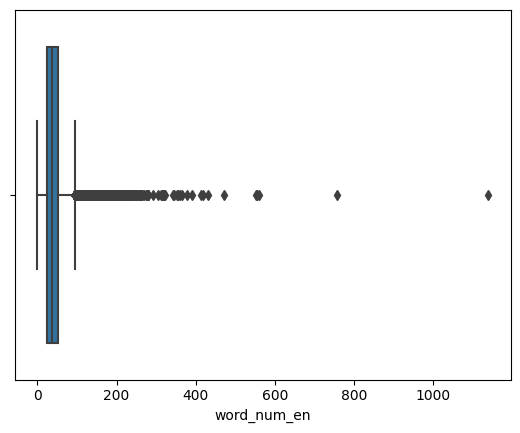

In [ ]:
import seaborn as sns
sns.boxplot(x='word_num_en', data=df);

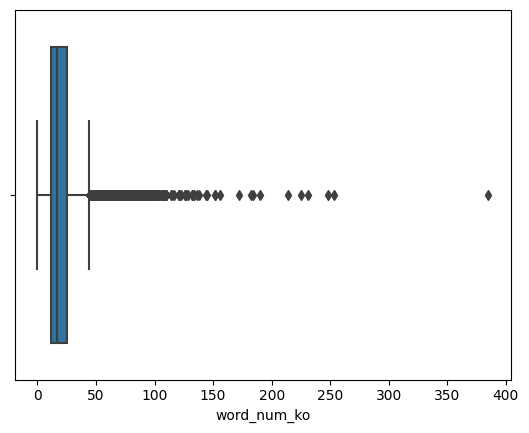

In [ ]:
sns.boxplot(x='word_num_ko', data=df);

In [ ]:
df.word_num_en.quantile(0.01)

8.0

In [ ]:
df.word_num_en.quantile(0.99)

124.0

In [ ]:
en_low = df.word_num_en.quantile(0.01)
en_high = df.word_num_en.quantile(0.99)

df.loc[(df.word_num_en < en_low) | (df.word_num_en > en_high)]

,category,law_name,en,ko,word_num_en,word_num_ko
66,헌법,개성공업지구 지원에 관한 법률,The Foundation shall perform the following tasks:,재단은 다음 각 호의 사업을 수행한다.,6,5
80,헌법,개성공업지구 지원에 관한 법률 시행령,A person who intends to pass through an area b...,도로차량으로 남한과 개성공업지구 간을 통행하려는 자는 통행차량 등록신청서를 접경지세...,125,33
161,헌법,겨레말큰사전남북공동편찬사업회법,The Joint Board shall perform the following ta...,편찬사업회는 다음 각 호의 사업을 수행한다.,7,5
246,헌법,남북 이산가족 생사확인 및 교류 촉진에 관한 법률,A master plan shall include the following matt...,기본계획에는 다음 각 호의 사항이 포함되어야 한다.,7,6
388,헌법,남북관계 발전에 관한 법률,A master plan shall include the following matt...,기본계획에는 다음 각 호의 사항이 포함되어야 한다.,7,6
...,...,...,...,...,...,...
275784,외무,재외공관 공증법,An observer may also serve as an interpreter.,참여인은 통역인을 겸할 수 있다.,7,4
275847,외무,재외공관 공증법 시행령,Receipt numbers shall be newly determined each...,접수번호는 해마다 새로 정하여야 한다.,7,4
275936,외무,재외국민보호를 위한 영사조력법,The Committee shall deliberate on the following:,위원회는 다음 각 호의 사항을 심의한다.,6,5
275941,외무,재외국민보호를 위한 영사조력법,Each general plan shall include the following:,기본계획에는 다음 각 호의 사항이 포함되어야 한다.,6,6


In [ ]:
df.word_num_ko.quantile(0.01)

4.0

In [ ]:
df.word_num_ko.quantile(0.99)

57.0

In [ ]:
ko_low = df.word_num_ko.quantile(0.01)
ko_high = df.word_num_ko.quantile(0.99)

df.loc[(df.word_num_ko < ko_low) | (df.word_num_ko > ko_high)]

,category,law_name,en,ko,word_num_en,word_num_ko
133,헌법,개성공업지구 지원에 관한 법률 시행령,The President shall be appointed by the Minist...,이사장은 통일부장관이 임명한다.,9,2
160,헌법,겨레말큰사전남북공동편찬사업회법,The Joint Board of South and North Korea for t...,겨레말큰사전남북공동편찬사업회는 법인으로 한다.,17,2
174,헌법,겨레말큰사전남북공동편찬사업회법,The auditor shall be appointed and dismissed b...,감사는 통일부장관이 임면한다.,11,2
360,헌법,남북 주민 사이의 가족관계와 상속 등에 관한 특례법,Any person who attempts to commit a crime spec...,제1항의 미수범은 처벌한다.,14,2
399,헌법,남북관계 발전에 관한 법률,Special envoys to North Korea shall be appoint...,대북특별사절은 대통령이 임명한다.,10,2
...,...,...,...,...,...,...
276207,외무,한국국제교류재단법,The auditor shall be appointed by the Minister...,감사는 외교부장관이 임명한다.,10,2
276215,외무,한국국제교류재단법,The board of directors shall be composed of di...,이사회는 이사로 구성한다.,8,2
276243,외무,한국국제협력단법,The Korea International Cooperation Agency sh...,한국국제협력단은 법인으로 한다.,10,2
276272,외무,한국국제협력단법,The board of directors shall be comprised of t...,이사회는 이사장과 이사로 구성한다.,11,3


In [ ]:
cut_id = df.loc[(df.word_num_en < en_low)|(df.word_num_en > en_high)|(df.word_num_ko < ko_low)|(df.word_num_ko > ko_high)].index
cut_id

Int64Index([    66,     80,    133,    160,    161,    174,    246,    360,
               388,    399,
            ...
            276068, 276094, 276133, 276162, 276182, 276207, 276215, 276243,
            276272, 276284],
           dtype='int64', length=7196)

In [ ]:
df2 = df.drop(index=cut_id)
df2

,category,law_name,en,ko,word_num_en,word_num_ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발 및 운영의 지원 및 개성공업지구에 투자하거나 출입 및 ...,61,30
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,이 법에서 사용하는 용어의 정의는 다음과 같다.,9,6
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적...",19,11
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 남북협력기금법 에 따른 남북협력기금을 지원 또는 융자...,22,11
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력 및 기술...,45,30
...,...,...,...,...,...,...
276353,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A Korean national worker for the United States...,국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국인 ...,53,23
276354,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"The Minister of National Defense shall, within...",국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 결과...,76,37
276355,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,Procedures for appeal and giving notice of dec...,제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 정한다.,27,11
276356,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"Costs necessary to pay subsidies, etc. under t...",이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.,14,9


In [ ]:



### 문자 대체 ###




In [ ]:
# '-'으로 시작하는 경우

df.loc[df.en.str.contains('^-')]

,category,law_name,en,ko
106245,재정ㆍ경제일반,부당특약 심사지침,----------------------------------------------...,<서면에 기재되지 아니한 사항에 포함되는 경우>
106250,재정ㆍ경제일반,부당특약 심사지침,"- (Example) Record of site condition, general ...",<부당특약 예시>
164451,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The date on which a contract is rescinded re...,"- 계약이 해제된 날은 전화, 우편등을 통한 해제신청이 상조사업자에게 도달한 날을 ..."
164468,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,"- A mutual aid association, deposit institutio...","－ 예치계약 대신 소비자피해보상을 위한 보험계약, 채무지급보증계약, 공제계약 중 어..."
164470,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Where he/she has concluded a contract that f...,－ 해당 상조계약과 관련한 법률관계가 모두 종료되었음을 증명하는 서류 또는 해당 소...
164475,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- If another contract to reserve advances is c...,"상조사업자는 재화등의 거래기록·소비자피해보상보험계약등의 체결내용을 방문, 전화, 인..."
164504,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The standard terms and conditions for mutual...,- 상조사업자는 위탁·제휴업체가 모집한 소비자에 대해서도 정보제공 등 모든 할부거래...
164509,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The transferring company and the acquiring c...,"- 인수업체가 ④에 따라 소비자피해보상보험계약등을 체결한 경우, 인도업체는 해당 회..."
164510,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The advances paid to the transferring compan...,- 개정 할부거래법 시행 이전에 상조계약을 체결한 소비자에게도 소비자피해보상증서를 ...
164511,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Where the acquiring company concludes a cons...,- 예치계좌의 예금주가 상조사업자이기 때문에 제3자인 소비자가 예치계좌 관련 정보를...


In [ ]:
df.loc[df.ko.str.contains('^-')]

,category,law_name,en,ko
106247,재정ㆍ경제일반,부당특약 심사지침,The illegality under Article 3-4 (2) 1 of the ...,"- (예시) 현장설명서, 입찰 및 견적 일반조건·특수조건, 설계도면, 시방서, 물량..."
164451,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The date on which a contract is rescinded re...,"- 계약이 해제된 날은 전화, 우편등을 통한 해제신청이 상조사업자에게 도달한 날을 ..."
164456,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,A mutual aid business operator may rescind a m...,- 상조사업자가 계약을 해제한 경우 소비자가 계약을 해제한 경우와 마찬가지로 3영업...
164496,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,<Examples of violations of the Act>,- 「신용정보의 이용 및 보호에 관한 법률」 제2조제5호에 따른 신용정보회사
164500,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,<Example of violation of the Act>,"- 상조서비스 표준약관은 양도시 실비수준의 수수료(예:5,000원)만을 받을 수 있..."
164504,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The standard terms and conditions for mutual...,- 상조사업자는 위탁·제휴업체가 모집한 소비자에 대해서도 정보제공 등 모든 할부거래...
164505,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,<Example of violation of the Act>,- 위탁·제휴업체는 자신의 고유업무상의 거래관계를 이용하여 상조상품 가입을 강요하여...
164509,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The transferring company and the acquiring c...,"- 인수업체가 ④에 따라 소비자피해보상보험계약등을 체결한 경우, 인도업체는 해당 회..."
164510,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- The advances paid to the transferring compan...,- 개정 할부거래법 시행 이전에 상조계약을 체결한 소비자에게도 소비자피해보상증서를 ...
164511,상업ㆍ무역ㆍ공업,선불식 할부거래에서의 소비자보호 지침,- Where the acquiring company concludes a cons...,- 예치계좌의 예금주가 상조사업자이기 때문에 제3자인 소비자가 예치계좌 관련 정보를...


In [ ]:
df.loc[df.en.str.contains('^\([0-9]+\)')]

,category,law_name,en,ko
8,헌법,개성공업지구 지원에 관한 법률,(1) The Government shall formulate and impleme...,① 정부는 개성공업지구를 국제적인 공업지구로 육성ㆍ발전시키기 위한 시책을 수립ㆍ시행...
9,헌법,개성공업지구 지원에 관한 법률,(2) The Government shall create conditions nec...,② 정부는 개성공업지구의 개발과 기업의 경영활동이 경제원리와 기업의 자율성을 바탕으...
10,헌법,개성공업지구 지원에 관한 법률,"(3) In developing the GIC, the Government shal...",③ 정부는 개성공업지구를 개발함에 있어서 남북한 주민의 복리증진과 산업안전을 위한 ...
11,헌법,개성공업지구 지원에 관한 법률,(4) The Government shall endeavor to ensure th...,④ 정부는 개성공업지구에서의 남북경제교류ㆍ협력을 민족내부거래의 원칙과 관행에 맞게 ...
12,헌법,개성공업지구 지원에 관한 법률,(5) Where it is deemed necessary for the devel...,⑤ 통일부장관은 개성공업지구를 개발하기 위하여 필요한 경우에 관계 중앙행정기관의 장...
...,...,...,...,...
276353,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
276354,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
276355,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) Procedures for appeal and giving notice of...,③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
276356,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(1) Costs necessary to pay subsidies, etc. und...",① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


In [ ]:
df.loc[df.ko.str.contains('^\([0-9]+\)')]

,category,law_name,en,ko


In [ ]:
df.loc[df.en.str.contains('^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]')]

,category,law_name,en,ko
8,헌법,개성공업지구 지원에 관한 법률,(1) The Government shall formulate and impleme...,① 정부는 개성공업지구를 국제적인 공업지구로 육성ㆍ발전시키기 위한 시책을 수립ㆍ시행...
9,헌법,개성공업지구 지원에 관한 법률,(2) The Government shall create conditions nec...,② 정부는 개성공업지구의 개발과 기업의 경영활동이 경제원리와 기업의 자율성을 바탕으...
10,헌법,개성공업지구 지원에 관한 법률,"(3) In developing the GIC, the Government shal...",③ 정부는 개성공업지구를 개발함에 있어서 남북한 주민의 복리증진과 산업안전을 위한 ...
11,헌법,개성공업지구 지원에 관한 법률,(4) The Government shall endeavor to ensure th...,④ 정부는 개성공업지구에서의 남북경제교류ㆍ협력을 민족내부거래의 원칙과 관행에 맞게 ...
12,헌법,개성공업지구 지원에 관한 법률,(5) Where it is deemed necessary for the devel...,⑤ 통일부장관은 개성공업지구를 개발하기 위하여 필요한 경우에 관계 중앙행정기관의 장...
...,...,...,...,...
276353,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(1) A Korean national worker for the United St...,① 국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국...
276354,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(2) The Minister of National Defense shall, wi...",② 국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 ...
276355,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) Procedures for appeal and giving notice of...,③ 제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 ...
276356,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"(1) Costs necessary to pay subsidies, etc. und...",① 이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


In [ ]:
error_id5 = df.loc[df.en.str.contains('-------------------------------------------------')].index
df.drop(index=error_id5, inplace=True)
df.loc[df.en.str.contains('-------------------------------------------------')]

,category,law_name,en,ko


In [ ]:
# 괄호숫자, 동글뱅이숫자 시작부분에 등장하는 경우

df.en = df.en.apply(lambda x: re.sub('^\([0-9]+\)|^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]|^-', '', str(x)).strip())
df.ko = df.ko.apply(lambda x: re.sub('^\([0-9]+\)|^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]|^-', '', str(x)).strip())

In [ ]:
df.loc[df.en.str.contains('^\([0-9]+\)|^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]|^-')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('^\([0-9]+\)|^[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮]|^-')]

,category,law_name,en,ko


In [ ]:
df.loc[df.en.str.contains('\([0-9]+\)')]

,category,law_name,en,ko
5,헌법,개성공업지구 지원에 관한 법률,Upon the occurrence of any event referred to i...,정부는 제12조의2제1항의 사유가 발생할 경우 개성공업지구 투자기업의 경영 안정 등...
6,헌법,개성공업지구 지원에 관한 법률,If an enterprise invested in the GIC intends t...,정부는 제12조의2제1항의 사유로 개성공업지구 투자기업이 생산시설을 국내로 이전하거...
7,헌법,개성공업지구 지원에 관한 법률,When taking necessary measures including suppo...,정부는 제12조의2제1항의 사유가 발생하여 제12조의3 및 제12조의4에 따른 지원...
14,헌법,개성공업지구 지원에 관한 법률,The Government or the providers of relevant fa...,"개성공업지구의 원활한 조성을 위하여 필요한 도로, 용수, 철도, 통신, 전기 등 기..."
15,헌법,개성공업지구 지원에 관한 법률,In relation to the support prescribed in parag...,정부는 제1항 및 제2항에 따른 지원을 함에 있어서 「산업입지 및 개발에 관한 법률...
...,...,...,...,...
276343,외무,해외이주법,(Transitional Measures on Emigration Agent) A ...,(해외이주알선업자에 관한 경과조치) 이 법 시행당시 종전의 규정에 의하여 해외이주알...
276349,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A subsidy paid under paragraph (1) shall be in...,제1항에 따라 지급되는 지원금은 「고용보험법」 제46조제1항제1호에 따른 금액으로 한다.
276350,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The detailed method for calculation and paymen...,"제1항 및 제2항에 따른 지원금의 구체적인 산정, 지급 방법 및 지급 기간 등에 관..."
276352,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The provisions of the Civil Procedure Act on s...,제1항의 송달에 관하여는 「민사소송법」의 송달에 관한 규정을 준용한다.


In [ ]:
df.loc[df.ko.str.contains('\([0-9]+\)')]

,category,law_name,en,ko
21213,민사법,가사소송법,(Enforcement Date) This Act shall enter into f...,"(시행일) 이 법은 공포한 날부터 시행한다. 다만, 제2조제1항가목(2)제13호 및..."
51439,지방제도,지방자치법 시행령,In cases of a City/Do with two administrative ...,행정부시장ㆍ행정부지사를 2명 두는 시ㆍ도의 경우에는 명칭을 행정(1)부시장ㆍ행정(1...
51447,지방제도,지방자치법 시행령,Where a City/Do has three Vice Mayors/Vice Gov...,법 제123조제1항제1호 및 제2호에 따라 부시장이나 부지사 3명을 두는 시ㆍ도의 ...
56584,민방위ㆍ소방,다중이용업소의 안전관리에 관한 특별법 시행령,"The safety facilities, etc. and interior decor...",하나의 건축물에 제2조제2호의 개정규정에 따른 복합영상물제공업의 업소(이 영 시행 ...
56585,민방위ㆍ소방,다중이용업소의 안전관리에 관한 특별법 시행령,A person who operates a private teaching insti...,제2조제3호나목(3)에 해당하는 학원으로서 그 건축물에 제2조제2호의 개정규정에 따...
...,...,...,...,...
253842,육운·항공·관광,관광진흥법 시행령,"The Minister of Culture, Sports and Tourism sh...",문화체육관광부장관은 별표 1 제2호사목(9)의 외국인환자 유치 의료기관 및 유치업자...
257133,육운·항공·관광,자동차관리법 시행령,(Enforcement Date) This Decree shall enter int...,"(시행일) 이 영은 1999년 10월 16일부터 시행한다. 다만, 제9조제1항의 개..."
257139,육운·항공·관광,자동차관리법 시행령,(Transitional Measures concerning Penalty Surc...,(과징금에 관한 경과조치) 이 영 시행전의 행위에 대한 과징금의 적용에 있어서는 별...
262461,해운,선박직원법,(Enforcement Date) This Act shall enter into f...,"(시행일) 이 법은 공포한 날부터 시행한다. 다만, 제2조제1호가목(4) 및 제4조..."


In [ ]:
# 괄호문자(숫자 아닌 것/숫자 포함 2글자 이상인 경우만, (),{},[], <>)

df.en = df.en.apply(lambda x: re.sub('\([^0-9\)]+\)|\([^\)]{2,}\)|\{[^\)]+\}|\[[^\]]+\]|\<[^\>]+\>', '', str(x).strip()))
df.ko = df.ko.apply(lambda x: re.sub('\([^0-9\)]+\)|\([^\)]{2,}\)|\{[^\)]+\}|\[[^\]]+\]|\<[^\>]+\>', '', str(x).strip()))

In [ ]:
df.loc[df.en.str.contains('\([^\)]+\)')]

,category,law_name,en,ko
5,헌법,개성공업지구 지원에 관한 법률,Upon the occurrence of any event referred to i...,정부는 제12조의2제1항의 사유가 발생할 경우 개성공업지구 투자기업의 경영 안정 등...
6,헌법,개성공업지구 지원에 관한 법률,If an enterprise invested in the GIC intends t...,정부는 제12조의2제1항의 사유로 개성공업지구 투자기업이 생산시설을 국내로 이전하거...
7,헌법,개성공업지구 지원에 관한 법률,When taking necessary measures including suppo...,정부는 제12조의2제1항의 사유가 발생하여 제12조의3 및 제12조의4에 따른 지원...
14,헌법,개성공업지구 지원에 관한 법률,The Government or the providers of relevant fa...,"개성공업지구의 원활한 조성을 위하여 필요한 도로, 용수, 철도, 통신, 전기 등 기..."
15,헌법,개성공업지구 지원에 관한 법률,In relation to the support prescribed in parag...,정부는 제1항 및 제2항에 따른 지원을 함에 있어서 「산업입지 및 개발에 관한 법률...
...,...,...,...,...
276343,외무,해외이주법,A person who has obtained permission of emigra...,이 법 시행당시 종전의 규정에 의하여 해외이주알선업의 허가를 받은 자는 이 법에 의...
276349,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A subsidy paid under paragraph (1) shall be in...,제1항에 따라 지급되는 지원금은 「고용보험법」 제46조제1항제1호에 따른 금액으로 한다.
276350,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The detailed method for calculation and paymen...,"제1항 및 제2항에 따른 지원금의 구체적인 산정, 지급 방법 및 지급 기간 등에 관..."
276352,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The provisions of the Civil Procedure Act on s...,제1항의 송달에 관하여는 「민사소송법」의 송달에 관한 규정을 준용한다.


In [ ]:
df.loc[df.ko.str.contains('\([^\)]+\)')]

,category,law_name,en,ko
21213,민사법,가사소송법,This Act shall enter into force on the date of...,"이 법은 공포한 날부터 시행한다. 다만, 제2조제1항가목(2)제13호 및 제14호,..."
51439,지방제도,지방자치법 시행령,In cases of a City/Do with two administrative ...,행정부시장ㆍ행정부지사를 2명 두는 시ㆍ도의 경우에는 명칭을 행정(1)부시장ㆍ행정(1...
51447,지방제도,지방자치법 시행령,Where a City/Do has three Vice Mayors/Vice Gov...,법 제123조제1항제1호 및 제2호에 따라 부시장이나 부지사 3명을 두는 시ㆍ도의 ...
56584,민방위ㆍ소방,다중이용업소의 안전관리에 관한 특별법 시행령,"The safety facilities, etc. and interior decor...",하나의 건축물에 제2조제2호의 개정규정에 따른 복합영상물제공업의 업소와 학원이 함께...
56585,민방위ㆍ소방,다중이용업소의 안전관리에 관한 특별법 시행령,A person who operates a private teaching insti...,제2조제3호나목(3)에 해당하는 학원으로서 그 건축물에 제2조제2호의 개정규정에 따...
...,...,...,...,...
245991,노동,공인노무사법 시행령,For persons who have at least a total of 10 ye...,법 제3조의3제2항에 따라 다음 각 호의 어느 하나에 해당하는 경력의 통산경력이 1...
253842,육운·항공·관광,관광진흥법 시행령,"The Minister of Culture, Sports and Tourism sh...",문화체육관광부장관은 별표 1 제2호사목(9)의 외국인환자 유치 의료기관 및 유치업자...
257133,육운·항공·관광,자동차관리법 시행령,This Decree shall enter into force on October ...,"이 영은 1999년 10월 16일부터 시행한다. 다만, 제9조제1항의 개정규정은 2..."
262461,해운,선박직원법,This Act shall enter into force on the date of...,"이 법은 공포한 날부터 시행한다. 다만, 제2조제1호가목(4) 및 제4조제2항제4호..."


In [ ]:
# 꺾쇠(「,」), 따옴표('), 쌍따옴표("), 말줄임표(…): 기호만 삭제

df.loc[df.en.str.contains('\'|\"|「|」|…')]

,category,law_name,en,ko
28,헌법,개성공업지구 지원에 관한 법률,(2) The foreign investment support center for ...,② 제1항에 따라 개성공업지구 현지기업을 설립한 외국인투자기업에 대한 지원업무를 종...
29,헌법,개성공업지구 지원에 관한 법률,(3) Article 15 of the Foreign Investment Promo...,③ 센터의 조직ㆍ운영에 관하여는 「외국인투자 촉진법」 제15조를 준용한다. 이 경우...
75,헌법,개성공업지구 지원에 관한 법률 시행령,"The term ""small and medium enterprise prescrib...",「개성공업지구 지원에 관한 법률」(이하 “법”이라 한다) 제2조제4호의2에서 “대통...
94,헌법,개성공업지구 지원에 관한 법률 시행령,(1) The scope of a fact-finding survey under A...,① 법 제12조의6제1항에 따른 실태조사(이하 “실태조사”라 한다)의 범위는 다음 ...
99,헌법,개성공업지구 지원에 관한 법률 시행령,(1) For purposes of applying the subparagraphs...,① 법 제13조제1항 각 호 및 법 제15조제1항제4호의 적용을 위하여 국민연금관리...
...,...,...,...,...
276254,외무,한국국제협력단법,Any person who is not the KOICA under this Act...,이 법에 따른 협력단이 아닌 자는 한국국제협력단 또는 이와 유사한 명칭을 사용하지 ...
276290,외무,한국국제협력단법,"(1) Any person who uses the title ""Korea Inter...",① 제27조를 위반하여 한국국제협력단 또는 이와 유사한 명칭을 사용한 자에게는 20...
276311,외무,해외이주법,"""Emigrants"" in this Act mean persons who emigr...","이 법에서 ""해외이주자""란 생업에 종사하기 위하여 외국에 이주하는 사람과 그 가족(..."
276321,외무,해외이주법,(1) Any person who intends to engage in the bu...,① 해외이주자를 모집ㆍ알선하거나 다음 각 호의 해외이주에 관한 업무를 업으로 하는 ...


In [ ]:
df.loc[df.ko.str.contains('\'|\"|「|」|…')]

,category,law_name,en,ko
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 「남북협력기금법」 에 따른 남북협력기금을 지원 또는 ...
5,헌법,개성공업지구 지원에 관한 법률,Upon the occurrence of any event referred to i...,정부는 제12조의2제1항의 사유가 발생할 경우 개성공업지구 투자기업의 경영 안정 등...
6,헌법,개성공업지구 지원에 관한 법률,If an enterprise invested in the GIC intends t...,정부는 제12조의2제1항의 사유로 개성공업지구 투자기업이 생산시설을 국내로 이전하거...
14,헌법,개성공업지구 지원에 관한 법률,(2) The Government or the providers of relevan...,"② 개성공업지구의 원활한 조성을 위하여 필요한 도로, 용수, 철도, 통신, 전기 등..."
15,헌법,개성공업지구 지원에 관한 법률,(3) In relation to the support prescribed in p...,③ 정부는 제1항 및 제2항에 따른 지원을 함에 있어서 「산업입지 및 개발에 관한 ...
...,...,...,...,...
276345,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The purpose of this Act is to provide for matt...,이 법은 「대한민국과 아메리카합중국 간의 상호방위조약 제4조에 의한 시설과 구역 및...
276346,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,The term “Korean national worker(s) for the Un...,"이 법에서 ""주한미군 소속 한국인 근로자""란 다음 각 호의 어느 하나에 해당하는 사..."
276349,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(2) A subsidy paid under paragraph (1) shall b...,② 제1항에 따라 지급되는 지원금은 「고용보험법」 제46조제1항제1호에 따른 금액으...
276350,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,(3) The detailed method for calculation and pa...,"③ 제1항 및 제2항에 따른 지원금의 구체적인 산정, 지급 방법 및 지급 기간 등에..."


In [ ]:
df.en = df.en.apply(lambda x: re.sub('\'|\"|「|」|…', '', str(x).strip()))
df.ko = df.ko.apply(lambda x: re.sub('\'|\"|「|」|…', '', str(x).strip()))

In [ ]:
df.loc[df.en.str.contains('\'|\"|「|」|…')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('\'|\"|「|」|…')]

,category,law_name,en,ko


In [ ]:
# [한국어만] ㆍ: ' 및 '으로 변환
# 그 전에 ㆍ여러개가 모여있는 행은 의미의 손실이 일어나있음을 확인
# ㆍ여러개 있는 행을 삭제 -> 나머지는 ' 및 '으로 변환 실행

df.loc[df.en.str.contains('ㆍ')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('ㆍ')]

,category,law_name,en,ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력ㆍ기술개발...
8,헌법,개성공업지구 지원에 관한 법률,The Government shall formulate and implement p...,정부는 개성공업지구를 국제적인 공업지구로 육성ㆍ발전시키기 위한 시책을 수립ㆍ시행하고...
10,헌법,개성공업지구 지원에 관한 법률,"In developing the GIC, the Government shall fo...",정부는 개성공업지구를 개발함에 있어서 남북한 주민의 복리증진과 산업안전을 위한 시책...
11,헌법,개성공업지구 지원에 관한 법률,The Government shall endeavor to ensure that i...,정부는 개성공업지구에서의 남북경제교류ㆍ협력을 민족내부거래의 원칙과 관행에 맞게 정착...
...,...,...,...,...
276297,외무,한국국제협력단법,The Corporation shall be dissolved at the same...,"공사는 한국해외개발공사법이 폐지됨과 동시에 해산되며, 공사의 재산과 권리ㆍ의무는 협..."
276299,외무,한국국제협력단법,The name of the Corporation entered in the reg...,제1항의 규정에 의하여 포괄승계된 재산과 권리ㆍ의무에 관한 등기부 기타 공부에 표시...
276321,외무,해외이주법,Any person who intends to engage in the busine...,해외이주자를 모집ㆍ알선하거나 다음 각 호의 해외이주에 관한 업무를 업으로 하는 사업...
276322,외무,해외이주법,A capital and guaranty insurance money require...,"제1항에 따른 등록을 위하여 필요한 자본금ㆍ보증보험금, 그 밖의 사항은 대통령령으로..."


In [ ]:
df.loc[df.ko.str.contains('ㆍㆍ')]

,category,law_name,en,ko
12459,국가공무원,공무원보수규정,The salary grades of public officials in offic...,이 영 시행당시 재직중인 ㆍㆍㆍㆍㆍ 및 의 봉급표를 적용받는 공무원의 호봉은 이 영...
12460,국가공무원,공무원보수규정,When calculating career experience of public o...,제1항의 규정에 의한 재직중인 공무원의 호봉재획정을 위한 경력산정에 있어서 ㆍㆍㆍㆍ...


In [ ]:
error_id6 = df.loc[df.ko.str.contains('ㆍㆍ')].index
df.drop(index=error_id6, inplace=True)
df.loc[df.ko.str.contains('ㆍㆍ')]

,category,law_name,en,ko


In [ ]:
df.ko = df.ko.apply(lambda x: re.sub('ㆍ', ' 및 ', str(x)).strip())
df.loc[df.ko.str.contains('ㆍ')]

,category,law_name,en,ko


In [ ]:
# '숫자)' 으로 시작하는 경우

df.loc[df.en.str.contains('^[\d]+\)')]

,category,law_name,en,ko
125711,관세,관세법 시행령,2) The decision to authorize the rehabilitatio...,종전의 회사정리법에 따른 정리계획인가의 결정은 제141조의2제1항제2호의 개정규정에...
159490,상업ㆍ무역ㆍ공업,대규모 유통업 분야의 특약매입거래에 관한 부당성 심사지침,1) Expenses for Interior of Sales Floor,"이 경우 대규모유통업자가 소요되는 인테리어 비용을 다음과 같이 분담하지 않을 경우,..."
159496,상업ㆍ무역ㆍ공업,대규모 유통업 분야의 특약매입거래에 관한 부당성 심사지침,2) Expenses of Promotional Staffs,상기 예외 규정에 따라 대규모유통업자가 입점업자로부터 판촉사원을 파견 받더라도 그 ...
159497,상업ㆍ무역ㆍ공업,대규모 유통업 분야의 특약매입거래에 관한 부당성 심사지침,3) Expenses for Management of Sales Floor,"또한, 대규모유통업자가 자신의 로고 또는 브랜드가 들어간 쇼핑백을 입점업자에게 사용..."


In [ ]:
df.loc[df.ko.str.contains('^[\d]+\)')]

,category,law_name,en,ko


In [ ]:
df.en = df.en.apply(lambda x: re.sub('^[\d]+\)', '', str(x)).strip())
df.loc[df.ko.str.contains('^[\d]+\)')]

,category,law_name,en,ko


In [ ]:
# 1-2) 삭제

df.drop(index=112045, inplace=True)

In [ ]:
# '숫자'로 시작하는 경우

df.loc[df.en.str.contains('^[\d]+')]

,category,law_name,en,ko
3437,선거ㆍ정당,공직선거법,240 days before the election day;,선거일 전 240일
3438,선거ㆍ정당,공직선거법,120 days before the election day;,선거일 전 120일
3439,선거ㆍ정당,공직선거법,90 days before the date an election period com...,선거기간개시일 전 90일
3440,선거ㆍ정당,공직선거법,60 days before the date an election period com...,선거기간개시일 전 60일
3447,선거ㆍ정당,공직선거법,60 days before the day when the election perio...,선거기간개시일 전 60일
3490,선거ㆍ정당,공직선거법,40 million won ＋ ;,4천만원＋
3491,선거ㆍ정당,공직선거법,40 million won ＋ ;,4천만원＋
3492,선거ㆍ정당,공직선거법,400 million won ＋ ;,4억원＋
3493,선거ㆍ정당,공직선거법,800 million won ＋ ;,8억원＋
3494,선거ㆍ정당,공직선거법,35 million won ＋ ;,3천500만원＋


In [ ]:
df.loc[df.ko.str.contains('^[\d]+')]

,category,law_name,en,ko
312,헌법,남북 주민 사이의 가족관계와 상속 등에 관한 특례법,If a person who has a spouse left in North Kor...,1953년 7월 27일 한국 군사정전에 관한 협정이 체결되기 전에 혼인하여 북한에 ...
400,헌법,남북관계 발전에 관한 법률,When at least two representatives of inter-Kor...,2인 이상의 남북회담대표 또는 대북특별사절을 임명할 경우에는 서열을 정하고 수석남북...
1565,헌법,상훈법,The first grade order shall be made to be affi...,1등급의 훈장은 대수로 한다.
1566,헌법,상훈법,The second and third grade orders shall be mad...,"2등급 및 3등급의 훈장은 중수로 한다. 다만, 2등급의 건국훈장 및 수교훈장은 대..."
1567,헌법,상훈법,The fourth and fifth grade orders shall be mad...,4등급 및 5등급의 훈장은 소수로 한다.
...,...,...,...,...
268937,정보통신,우정사업 운영에 관한 특례법,Budget execution and settlement of accounts in...,1997회계연도의 통신사업특별회계 및 체신보험특별회계의 예산의 집행 및 결산은 종전...
269413,정보통신,우편법,Letter boxes shall be installed at buildings o...,3층 이상의 고층건물로서 그 전부 또는 일부를 주택 및 사무소 또는 사업소로 사용하...
273831,정보통신,정보통신산업 진흥법,"Charges imposed before December 31, 2012 under...",2012년 12월 31일 이전에 종전의 제43조에 따라 부과된 부담금에 관하여는 종...
275464,외무,여권법,Where a person under 18 years of age intends t...,18세 미만인 사람이 제1항에 따라 여권을 발급받으려는 경우에는 법정대리인의 동의를...


In [ ]:
# % -> 영어에서는 'percent', 국어에서는 '퍼센트'로 통일

df.loc[df.en.str.contains('%')]

,category,law_name,en,ko,word_num_en,word_num_ko
77941,교육ㆍ학술,외국인학교 및 외국인유치원의 설립운영에 관한 규정,The proportion of nationals referred to in par...,제1항에 해당하는 내국인은 외국인학교 학생 정원의 30퍼센트를 넘지 아니하도록 하되...,71,29
95726,과학ㆍ기술,산업기술혁신사업 공통 운영요령,A participating researcher for a project for w...,제1항에 따라 사업을 신청하는 해당 사업의 참여연구원은 참여율이 10% 이상이어야 ...,80,46
95758,과학ㆍ기술,산업기술혁신사업 공통 운영요령,Where a middle-standng or small-medium enterpr...,중견·중소기업이 외부 기술도입을 한 경우 평가위원회 또는 연구발표회의 심의를 거쳐 ...,79,35
95813,과학ㆍ기술,산업기술혁신사업 공통 운영요령,The head of an agency vested with exclusive re...,전담기관의 장은 중단 평가를 받은 과제에 한하여 원인보고서 작성·논문작성·특허출원 ...,77,37
100621,재정ㆍ경제일반,경품류제공에관한불공정거래행위의유형및기준지정고시,The expected sales price referred to in paragr...,"제1항과 제2항의 예상매출액은 다음 각호의 방법에 의하여 산정한다. 다만, 매출액이...",84,33
108337,재정ㆍ경제일반,외국인투자지역운영지침,"Regarding the site, where a relocated company ...","부지의 경우, 관리기관은 입주기업이 건축면적을 충족하지 못할 경우 제37조제1호의 ...",48,18
113783,내국세,법인세법,The withholding tax rate on interest income fr...,1998년 9월 30일이전에 발행된 종전의 제39조제6항의 규정에 의한 채권등의 이...,32,17
114745,내국세,법인세법 시행령,In applying the amended provisions of Article ...,제47조제1항의 개정규정을 적용함에 있어서 1999년 12월 31일이 속하는 사업연...,31,17
216323,약사,약사법 시행령,A person who scores at least 40% in each subje...,"한약조제시험의 합격자는 각 과목 만점의 40퍼센트 이상, 전 과목 총점의 60퍼센트...",25,14


In [ ]:
df.loc[df.ko.str.contains('%')]

,category,law_name,en,ko,word_num_en,word_num_ko
95726,과학ㆍ기술,산업기술혁신사업 공통 운영요령,A participating researcher for a project for w...,제1항에 따라 사업을 신청하는 해당 사업의 참여연구원은 참여율이 10% 이상이어야 ...,80,46
95758,과학ㆍ기술,산업기술혁신사업 공통 운영요령,Where a middle-standng or small-medium enterpr...,중견·중소기업이 외부 기술도입을 한 경우 평가위원회 또는 연구발표회의 심의를 거쳐 ...,79,35
95813,과학ㆍ기술,산업기술혁신사업 공통 운영요령,The head of an agency vested with exclusive re...,전담기관의 장은 중단 평가를 받은 과제에 한하여 원인보고서 작성·논문작성·특허출원 ...,77,37
100619,재정ㆍ경제일반,경품류제공에관한불공정거래행위의유형및기준지정고시,If the total value of premiums offered by a bu...,사업자가 소비자현상경품으로 제공하는 경품가액의 합계액이 경품부상품 또는 용역의 예상...,120,44
100620,재정ㆍ경제일반,경품류제공에관한불공정거래행위의유형및기준지정고시,"Notwithstanding paragraph (1), the upper limit...","제1항의 규정에 불구하고 정기간행물출판업, 경기후원업 및 방송업을 영위하는 사업자의...",36,16
100621,재정ㆍ경제일반,경품류제공에관한불공정거래행위의유형및기준지정고시,The expected sales price referred to in paragr...,"제1항과 제2항의 예상매출액은 다음 각호의 방법에 의하여 산정한다. 다만, 매출액이...",84,33
108194,재정ㆍ경제일반,외국인투자지역운영지침,A down payment for the purchase of land in a f...,"외국인투자지역 부지매입시 계약금은 국가와 지자체가 총액의 50%씩 각각 분담하며, ...",80,29
108241,재정ㆍ경제일반,외국인투자지역운영지침,The area allowed for a subcontractor to move i...,협력업체의 입주허용 면적은 해당 입주업체의 공장건축면적의 30%를 초과 할 수 없...,59,20
108252,재정ㆍ경제일반,외국인투자지역운영지침,The area that an entity engaged in electricity...,제1항에 따라 입주가 허용된 발전사업자의 입주허용 면적은 공장건축 면적의 30%를 ...,96,43
108293,재정ㆍ경제일반,외국인투자지역운영지침,A newly or additionally designated zone or bu...,"신규 및 추가 지정 지역 또는 건물은 즉시 입주가 가능하여야 하며, 외국인투자기업의...",73,35


In [ ]:
df.loc[df.en.str.contains('percent')]

,category,law_name,en,ko,word_num_en,word_num_ko
1321,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Ratio ... prescribed by Presidential Decree in...,법 제17조의5제1항제2호에서 “대통령령으로 정하는 비율”이란 연간 5퍼센트를 말한다.,17,7
4417,선거ㆍ정당,공직선거법,The percentage of votes obtained in the electi...,제2항의 비례대표국회의원선거 득표비율은 각 의석할당정당의 득표수를 모든 의석할당정당...,43,11
10038,행정일반,책임운영기관의 설치·운영에 관한 법률,Affiliated responsible administrative agencies...,제1항에 따라 책임운영기관특별회계로 운영할 필요가 있는 소속책임운영기관은 재정수입 ...,60,25
10170,행정일반,청년기본법,The head of a relevant central administrative ...,관계 중앙행정기관의 장 및 시 및 도지사는 청년정책을 주로 다루는 위원회를 구성할 ...,57,33
11562,국가공무원,공공재정 부정청구 금지 및 부정이익 환수 등에 관한 법률 시행령,A monetary reward under Article 23 (3) of the ...,법 제23조제3항에 따른 보상금은 보상대상가액의 30퍼센트로 한다.,21,6
...,...,...,...,...,...,...
271833,정보통신,전파법 시행령,Where the security deposit and price for radio...,법 제11조제5항 및 제6항에 따라 보증금 및 주파수할당 대가를 방송통신발전기금 및...,69,26
272172,정보통신,전파법 시행령,Where an inspection is conducted on each trans...,법 제10조에 따라 과학기술정보통신부장관이 할당한 주파수를 이용하는 기간통신사업자의...,76,31
272173,정보통신,전파법 시행령,In cases of the following radio stations in wh...,제69조제1항제1호 및 제2호에 해당하는 무선설비를 둘 이상의 기간통신사업자나 방송...,69,24
272267,정보통신,정보보호산업의 진흥에 관한 법률,Where a person who has disclosed the current s...,제1항에 따라 정보보호 현황을 공개한 자가 정보통신망 이용촉진 및 정보보호 등에 관...,60,30


In [ ]:
df.loc[df.ko.str.contains('퍼센트')]

,category,law_name,en,ko,word_num_en,word_num_ko
1321,헌법,북한이탈주민의 보호 및 정착지원에 관한 법률 시행령,Ratio ... prescribed by Presidential Decree in...,법 제17조의5제1항제2호에서 “대통령령으로 정하는 비율”이란 연간 5퍼센트를 말한다.,17,7
11562,국가공무원,공공재정 부정청구 금지 및 부정이익 환수 등에 관한 법률 시행령,A monetary reward under Article 23 (3) of the ...,법 제23조제3항에 따른 보상금은 보상대상가액의 30퍼센트로 한다.,21,6
11567,국가공무원,공공재정 부정청구 금지 및 부정이익 환수 등에 관한 법률 시행령,Where a monetary reward is reduced under parag...,제1항에 따라 보상금을 감액하는 경우 제1항 각 호의 사항별 감액 한도는 30퍼센트...,83,37
11609,국가공무원,공무원 성과평가 등에 관한 규정,With respect to the evaluation of performance ...,고위공무원단에 속하는 공무원에 대한 성과계약등 평가의 평가등급별 인원 분포 비율은 ...,91,40
11620,국가공무원,공무원 성과평가 등에 관한 규정,"The evaluation grades shall be three or more, ...","평가등급의 수는 3개 이상으로 하며, 최상위 등급의 인원은 평가 단위별 인원수의 상...",68,36
...,...,...,...,...,...,...
271144,정보통신,전기통신사업법 시행령,Amount calculated according to criteria prescr...,법 제32조제4항 본문에서 “대통령령으로 정하는 기준에 따라 산정된 금액”이란 선불...,65,28
271833,정보통신,전파법 시행령,Where the security deposit and price for radio...,법 제11조제5항 및 제6항에 따라 보증금 및 주파수할당 대가를 방송통신발전기금 및...,69,26
272172,정보통신,전파법 시행령,Where an inspection is conducted on each trans...,법 제10조에 따라 과학기술정보통신부장관이 할당한 주파수를 이용하는 기간통신사업자의...,76,31
272173,정보통신,전파법 시행령,In cases of the following radio stations in wh...,제69조제1항제1호 및 제2호에 해당하는 무선설비를 둘 이상의 기간통신사업자나 방송...,69,24


In [ ]:
df.loc[(df.en.str.contains('/100'))&(df.ko.str.contains('퍼센트|%'))]

,category,law_name,en,ko,word_num_en,word_num_ko
31698,민사법,주식회사 등의 외부감사에 관한 법률 시행령,The Korea Accounting Institute shall accumulat...,한국회계기준원은 매년 총지출 예산의 10퍼센트에 해당하는 금액을 직전 2개 사업연도...,34,15
31699,민사법,주식회사 등의 외부감사에 관한 법률 시행령,"Pursuant to Article 5 (6) of the Act, the Fina...",금융위원회의 설치 등에 관한 법률에 따라 설립된 금융감독원은 법 제5조제6항에 따라...,109,42
31835,민사법,주식회사 등의 외부감사에 관한 법률 시행령,"Notwithstanding paragraph (3), the Securities ...",제3항에도 불구하고 증권선물위원회는 법 제29조제3항제3호에 해당하는 회계법인에 직...,42,18
45770,지방제도,제주특별자치도 설치 및 국제자유도시 조성을 위한 특별법,"Notwithstanding Articles 43 (2), 77, and 78 of...",제주자치도에 설치하는 도시 및 군계획시설 중 유원지시설의 결정 및 구조 및 설치의 ...,69,39
97159,과학ㆍ기술,연구개발특구의 육성에 관한 특별법 시행령,The State or a local government may subsidize ...,국가 또는 지방자치단체는 연구개발특구위원회의 심의 및 의결을 거쳐 제1항 각 호의 ...,31,16
196830,주택·건축·도로,빈집 및 소규모주택 정비에 관한 특례법,Where a project implementer constructs at leas...,사업시행자가 전체 세대수의 10퍼센트 이상을 임대주택으로 건설하고 제1항에 따라 용...,96,33
218873,사회복지,국민연금과 직역연금의 연계에 관한 법률 시행령,"Notwithstanding paragraph (2) 2 , where the di...",제2항제2호나목에도 불구하고 같은 목에 따른 이자율과 반납금등의 분할 납부 중의 이...,73,41
252946,육운·항공·관광,공항소음 방지 및 소음대책지역 지원에 관한 법률 시행령,“A rate prescribed by Presidential Decree” in ...,법 제14조제2항 단서에서 “대통령령으로 정하는 비율”이란 30퍼센트를 말한다.,17,7
271144,정보통신,전기통신사업법 시행령,Amount calculated according to criteria prescr...,법 제32조제4항 본문에서 “대통령령으로 정하는 기준에 따라 산정된 금액”이란 선불...,65,28


In [ ]:
##############################################

error_id11 = df.loc[(df.en.str.contains('/100'))&(df.ko.str.contains('퍼센트|%'))].index
df.iloc[error_id11,2] = df.iloc[error_id11,2].apply(lambda x: re.sub('/100', '%', str(x)))
df.loc[(df.en.str.contains('/100'))&(df.ko.str.contains('퍼센트|%'))]

,category,law_name,en,ko,word_num_en,word_num_ko
31698,민사법,주식회사 등의 외부감사에 관한 법률 시행령,The Korea Accounting Institute shall accumulat...,한국회계기준원은 매년 총지출 예산의 10%에 해당하는 금액을 직전 2개 사업연도 총...,34,15
31699,민사법,주식회사 등의 외부감사에 관한 법률 시행령,"Pursuant to Article 5 (6) of the Act, the Fina...",금융위원회의 설치 등에 관한 법률에 따라 설립된 금융감독원은 법 제5조제6항에 따라...,109,42
31835,민사법,주식회사 등의 외부감사에 관한 법률 시행령,"Notwithstanding paragraph (3), the Securities ...",제3항에도 불구하고 증권선물위원회는 법 제29조제3항제3호에 해당하는 회계법인에 직...,42,18
45770,지방제도,제주특별자치도 설치 및 국제자유도시 조성을 위한 특별법,"Notwithstanding Articles 43 (2), 77, and 78 of...",제주자치도에 설치하는 도시 및 군계획시설 중 유원지시설의 결정 및 구조 및 설치의 ...,69,39
97159,과학ㆍ기술,연구개발특구의 육성에 관한 특별법 시행령,The State or a local government may subsidize ...,국가 또는 지방자치단체는 연구개발특구위원회의 심의 및 의결을 거쳐 제1항 각 호의 ...,31,16
196830,주택·건축·도로,빈집 및 소규모주택 정비에 관한 특례법,Where a project implementer constructs at leas...,사업시행자가 전체 세대수의 10% 이상을 임대주택으로 건설하고 제1항에 따라 용적률...,96,33
218873,사회복지,국민연금과 직역연금의 연계에 관한 법률 시행령,"Notwithstanding paragraph (2) 2 , where the di...",제2항제2호나목에도 불구하고 같은 목에 따른 이자율과 반납금등의 분할 납부 중의 이...,73,41
252946,육운·항공·관광,공항소음 방지 및 소음대책지역 지원에 관한 법률 시행령,“A rate prescribed by Presidential Decree” in ...,법 제14조제2항 단서에서 “대통령령으로 정하는 비율”이란 30%를 말한다.,17,7
271144,정보통신,전기통신사업법 시행령,Amount calculated according to criteria prescr...,법 제32조제4항 본문에서 “대통령령으로 정하는 기준에 따라 산정된 금액”이란 선불...,65,28


In [ ]:
df.en = df.en.apply(lambda x: re.sub('percent', '%', str(x)))
df.ko = df.ko.apply(lambda x: re.sub('퍼센트', '%', str(x)))

In [ ]:
df.loc[df.en.str.contains('%')]

,category,law_name,en,ko


In [ ]:
df.loc[df.ko.str.contains('%')]

,category,law_name,en,ko


In [ ]:
# 전처리로 인해 생긴 빈문자열이나 nan 값 확인 후 삭제



In [ ]:
# 마지막으로 인덱스 초기화

df.reset_index(drop=True, inplace=True)

In [ ]:
df

,category,law_name,en,ko
0,헌법,개성공업지구 지원에 관한 법률,The purpose of this Act is to enhance inter-Ko...,이 법은 개성공업지구의 개발 및 운영의 지원 및 개성공업지구에 투자하거나 출입 및 ...
1,헌법,개성공업지구 지원에 관한 법률,The terms used in this Act are defined as foll...,이 법에서 사용하는 용어의 정의는 다음과 같다.
2,헌법,개성공업지구 지원에 관한 법률,This Act shall prevail over other statutes wit...,"개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적..."
3,헌법,개성공업지구 지원에 관한 법률,The Government may grant or lend to a local en...,정부는 개성공업지구 현지기업에 남북협력기금법 에 따른 남북협력기금을 지원 또는 융자...
4,헌법,개성공업지구 지원에 관한 법률,In addition to the business support under this...,이 법에 정한 기업 지원에 관한 사항 이외에 다른 법률이 정하고 있는 인력 및 기술...
...,...,...,...,...
273284,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,A Korean national worker for the United State...,국방부장관이 제5조에 따라 결정한 사항에 대하여 이의가 있는 주한미군 소속 한국인...
273285,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"The Minister of National Defense shall, withi...",국방부장관은 이의신청을 받은 날부터 7일 이내에 그 이의신청에 대하여 결정하고 결...
273286,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,Procedures for appeal and giving notice of de...,제1항과 제2항에 따른 신청 절차와 결정 통지 등에 필요한 사항은 국방부령으로 정한다.
273287,-,주한미군 소속 한국인 근로자의 지원을 위한 특별법,"Costs necessary to pay subsidies, etc. under ...",이 법에 따른 지원금의 지급 등에 필요한 비용은 국가에서 부담한다.


In [ ]:
# 전처리 완료한 데이터 따로 저장

df.to_csv('/content/drive/MyDrive/KBdata/processed_df.csv', index=False)

# 4. 토크나이징
- 한국어 형태소 분석기 활용해서 품사태깅
  
  - Hannanum (고유명사 가장 분류 잘 하는 듯)
  - Okt
  - Kkma

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.9 MB/s eta 0:00:00


In [ ]:
df.iloc[:3, -1]

0    이 법은 개성공업지구의 개발ㆍ운영의 지원 및 개성공업지구에 투자하거나 출입ㆍ체류하는...
1                          이 법에서 사용하는 용어의 정의는 다음과 같다. 
2    개성공업지구에 대한 지원, 왕래와 교역에 관하여는 다른 법률에 우선하여 이 법을 적...
Name: ko, dtype: object

In [ ]:
from konlpy.tag import Hannanum

hannanum = Hannanum()
kor = df.iloc[:3, -1]

for k in kor:
  morphs = hannanum.morphs(k)
  pos = hannanum.pos(k)
  print('morphs:',morphs)
  print('pos:',pos)

morphs: ['이', '법', '은', '개성공업지구', '의', '개발ㆍ운영', '의', '지원', '및', '개성공업지구', '에', '투자하', '이', '거나', '출입ㆍ체류하', '는', '남한주민', '의', '보호ㆍ지원', '에', '관하', '어', '필요', '하', 'ㄴ', '사항', '을', '규정함', '으로써', '남북교류ㆍ협력', '을', '증진', '하고', '민족경제', '의', '균형적', '이', 'ㄴ', '발전', '에', '기이', '어', '하', 'ㅁ', '을', '목적', '으로', '하', 'ㄴ다', '.']
pos: [('이', 'M'), ('법', 'N'), ('은', 'J'), ('개성공업지구', 'N'), ('의', 'J'), ('개발ㆍ운영', 'N'), ('의', 'J'), ('지원', 'N'), ('및', 'M'), ('개성공업지구', 'N'), ('에', 'J'), ('투자하', 'N'), ('이', 'J'), ('거나', 'E'), ('출입ㆍ체류하', 'N'), ('는', 'J'), ('남한주민', 'N'), ('의', 'J'), ('보호ㆍ지원', 'N'), ('에', 'J'), ('관하', 'P'), ('어', 'E'), ('필요', 'N'), ('하', 'X'), ('ㄴ', 'E'), ('사항', 'N'), ('을', 'J'), ('규정함', 'N'), ('으로써', 'J'), ('남북교류ㆍ협력', 'N'), ('을', 'J'), ('증진', 'N'), ('하고', 'J'), ('민족경제', 'N'), ('의', 'J'), ('균형적', 'N'), ('이', 'J'), ('ㄴ', 'E'), ('발전', 'N'), ('에', 'J'), ('기이', 'P'), ('어', 'E'), ('하', 'P'), ('ㅁ', 'E'), ('을', 'J'), ('목적', 'N'), ('으로', 'J'), ('하', 'P'), ('ㄴ다', 'E'), ('.', 'S')]
morphs: ['이', '법', '에서', 

In [ ]:
from konlpy.tag import Okt

okt = Okt()
kor = df.iloc[:3, -1]

for k in kor:
  morphs = okt.morphs(k)
  pos = okt.pos(k)
  print('morphs:',morphs)
  print('pos:',pos)

morphs: ['이', '법', '은', '개성', '공업', '지구', '의', '개발', 'ㆍ', '운영', '의', '지원', '및', '개성', '공업', '지구', '에', '투자', '하', '거나', '출입', 'ㆍ', '체류', '하는', '남한', '주민', '의', '보호', 'ㆍ', '지원', '에', '관', '하여', '필요한', '사항', '을', '규정', '함', '으로써', '남북', '교류', 'ㆍ', '협력', '을', '증진', '하고', '민족', '경제', '의', '균형', '적', '인', '발전', '에', '기여', '함', '을', '목적', '으로', '한다', '.']
pos: [('이', 'Noun'), ('법', 'Noun'), ('은', 'Josa'), ('개성', 'Noun'), ('공업', 'Noun'), ('지구', 'Noun'), ('의', 'Josa'), ('개발', 'Noun'), ('ㆍ', 'Foreign'), ('운영', 'Noun'), ('의', 'Josa'), ('지원', 'Noun'), ('및', 'Noun'), ('개성', 'Noun'), ('공업', 'Noun'), ('지구', 'Noun'), ('에', 'Josa'), ('투자', 'Noun'), ('하', 'Suffix'), ('거나', 'Noun'), ('출입', 'Noun'), ('ㆍ', 'Foreign'), ('체류', 'Noun'), ('하는', 'Verb'), ('남한', 'Noun'), ('주민', 'Noun'), ('의', 'Josa'), ('보호', 'Noun'), ('ㆍ', 'Foreign'), ('지원', 'Noun'), ('에', 'Josa'), ('관', 'Noun'), ('하여', 'Verb'), ('필요한', 'Adjective'), ('사항', 'Noun'), ('을', 'Josa'), ('규정', 'Noun'), ('함', 'Noun'), ('으로써', 'Josa'), ('남북', 'Noun'), 

In [ ]:
from konlpy.tag import Kkma

kkma = Kkma()
kor = df.iloc[:3, -1]

for k in kor:
  morphs = kkma.morphs(k)
  pos = kkma.pos(k)
  print('morphs:',morphs)
  print('pos:',pos)

morphs: ['이', '법', '은', '개성', '공업', '지구의', '개발ㆍ운영', '의', '지원', '및', '개성', '공업', '지구', '에', '투자', '하', '거나', '출입ㆍ체류하', '는', '남한', '주민', '의', '보호ㆍ지원', '에', '관하', '여', '필요', '하', 'ㄴ', '사항', '을', '규정', '하', 'ㅁ', '으로써', '남북교류ㆍ협력', '을', '증진', '하', '고', '민족', '경제', '의', '균형', '적', '이', 'ㄴ', '발전', '에', '기여', '하', 'ㅁ', '을', '목적', '으로', '하', 'ㄴ다', '.']
pos: [('이', 'MDT'), ('법', 'NNG'), ('은', 'JX'), ('개성', 'NNG'), ('공업', 'NNG'), ('지구의', 'NNG'), ('개발ㆍ운영', 'UN'), ('의', 'JKG'), ('지원', 'NNG'), ('및', 'MAG'), ('개성', 'NNG'), ('공업', 'NNG'), ('지구', 'NNG'), ('에', 'JKM'), ('투자', 'NNG'), ('하', 'XSV'), ('거나', 'ECE'), ('출입ㆍ체류하', 'UN'), ('는', 'JX'), ('남한', 'NNG'), ('주민', 'NNG'), ('의', 'JKG'), ('보호ㆍ지원', 'UN'), ('에', 'JKM'), ('관하', 'VV'), ('여', 'ECS'), ('필요', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('사항', 'NNG'), ('을', 'JKO'), ('규정', 'NNG'), ('하', 'XSV'), ('ㅁ', 'ETN'), ('으로써', 'JKM'), ('남북교류ㆍ협력', 'UN'), ('을', 'JKO'), ('증진', 'NNG'), ('하', 'XSV'), ('고', 'ECE'), ('민족', 'NNG'), ('경제', 'NNG'), ('의', 'JKG'), ('균형', 'NNG'),